# Toxic comment classification

## Introduction

The project uses the Wikipedia commment classification dataset uploaded from the Kaggle website (https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge). The dataset includes two csv files: 
- train.csv with 159571 entries, each containing columns of Wikipedia comments and columns with info if the comments  are labeled as toxic, severe_toxic, obscene, threat, insult, or identity_hate (the labels are one-hot encoded; 0 represents the absence of the characteristic refered by the label and 1 represents the presence).
- test.csv with 153164 entries, each containg comments, but missing the labels; this file will be used for testing.

The purpose of the project is to apply natural language processing and techniques to train multi-label classification  models to automatically analyze all messages users write and flag toxic users/comments.

The project consists of two parts: 1) the exploratory analysis of the dataset of Wikipedia comments and 2) building, training, fine-tuning and evaluating classifiers able to predict comment labels (to identify comments which could be characterized as inapropriate.

### Connecting to the Hugging Face repository and importing libraries

The first step is to connect to the Hugging Face repository which contains a number of pretrained deep learning models. Some of these models will be used for training and fine-tuning the multi-label classifiers. 

In [1]:
import huggingface_hub

huggingface_hub.login()

The main libraries which will be used for the manipulation with data are pandas and numpy. Matplotlib and seaborn will be used for data visualization. For the exploratory analysis such libraries as nltk, gensim, worldcloud, textblob will be used. Various modules of the torch library, transformers from the Hugging Face repository as well as pytorch-lightning will be used for data loading, importing pretrained models, training, summarizing and fine-tuning. Sklearn metrics will be used for presenting confusion matrix and classification report. The dataset class is imported from a separate python file.

The modelling was performed on the Mac computer with the M2 processor (10 GPU cores). 

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.metrics import multilabel_confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight


import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch import optim
from torchsummary import summary

import pytorch_lightning as pl

import transformers
from transformers import (
    AutoTokenizer,
    DistilBertTokenizer,
    DistilBertForMaskedLM,
    DistilBertModel,
    DistilBertForSequenceClassification,
    DistilBertConfig,
    pipeline,
)

import re
import pickle

from tokenizers import trainers, models, Tokenizer, pre_tokenizers
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.corpus import stopwords
import gensim
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

from collections import defaultdict
from collections import Counter
from typing import Any, List, Tuple, Union

import warnings

warnings.filterwarnings("ignore")

from comments_dataset import WikipediaCommentDataset

<IPython.core.display.Javascript object>

In [5]:
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

## 1. Exploratory data analysis

### Importing data

The csv files with the comments data are imported into train and test dataframes.

In [6]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")


<IPython.core.display.Javascript object>

The basic information on these dataframes is presented bellow.

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


<IPython.core.display.Javascript object>

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            153164 non-null  object
 1   comment_text  153164 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


<IPython.core.display.Javascript object>

In [9]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


<IPython.core.display.Javascript object>

In [10]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


<IPython.core.display.Javascript object>

### Initial data  preprocessing

It can be seen that there are many special characters in the dataframes that do not contain any information. In order to remove them, the function 'clean text' is created and applied to both train and test dataframes.

In [11]:
def clean_text(text: str) -> str:
    """
    Cleans the given text by removing extra spaces and special characters.

    Args:
        text (str): The text to be cleaned.

    Returns:
        str: The cleaned text.
    """
    text = " ".join(text.split())
    text = re.sub("[^A-Za-z0-9,.!? ]+", "", text)
    return text

<IPython.core.display.Javascript object>

In [12]:
train['comment_text'] = train['comment_text'].apply(clean_text)
test['comment_text'] = test['comment_text'].apply(clean_text)


<IPython.core.display.Javascript object>

It can be observed that unneeded characters are removed (see bellow).

In [13]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then youll ...
1,0000247867823ef7,"From RfC The title is fine as it is, IMO."
2,00013b17ad220c46,Sources Zawe Ashton on Lapland
3,00017563c3f7919a,"If you have a look back at the source, the inf..."
4,00017695ad8997eb,I dont anonymously edit articles at all.


<IPython.core.display.Javascript object>

The function 'output_label" is created to convert elements from the label list into numbers. Numbers will be needed for the training of the model and labels will be needed for interpreting prediction results.

In [14]:
label_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

<IPython.core.display.Javascript object>

In [15]:
label_numbers = [1, 2, 3, 4, 5, 6]

<IPython.core.display.Javascript object>

In [16]:
def output_label(label: Union[torch.Tensor, int]) -> str:
    """
    Takes in a label and returns the corresponding label name.

    Parameters:
        label (torch.Tensor or int): The label to be converted.

    Returns:
        str: The corresponding label name.
    """
    output_mapping = {
        0: label_names[0],
        1: label_names[1],
        2: label_names[2],
        3: label_names[3],
        4: label_names[4],
        5: label_names[5],
    }
    input = label.item() if type(label) == torch.Tensor else label
    return output_mapping[input]

<IPython.core.display.Javascript object>

### Checking for missing values and duplicates

The datasets are also checked for missing values and duplicates.

In [17]:
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

<IPython.core.display.Javascript object>

In [18]:
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

<IPython.core.display.Javascript object>

In [19]:
duplicates_train = train[train.duplicated()]
duplicates_test = test[test.duplicated()]
if (len(duplicates_train) != 0) or (len(duplicates_train) != 0):
    print("\nNumber of duplicates in the train dataframe:", len(duplicates_train))
    print("\nNumber of duplicates in the test dataframe:", len(duplicates_test))
else:
    print("There are no duplicates in the dataframes.")
print("Duplicate Rows:")
print(duplicates_train)
print(duplicates_test)


There are no duplicates in the dataframes.
Duplicate Rows:
Empty DataFrame
Columns: [id, comment_text, toxic, severe_toxic, obscene, threat, insult, identity_hate]
Index: []
Empty DataFrame
Columns: [id, comment_text]
Index: []


<IPython.core.display.Javascript object>

it appears that there are no missing values and duplicates in the dataframes.

### Analysis of target variables in the train dataset

The train dataframe includes comments which are multi-labeled, that is, the same comment could be identified with several labels. Thus, it is useful to know what is the number of comments which could be considered as appropriate (that get 0 values in every column of toxic comments labels.

In [20]:
appropriate = train["id"][
    (train["toxic"] != 1)
    & (train["severe_toxic"] != 1)
    & (train["obscene"] != 1)
    & (train["threat"] != 1)
    & (train["insult"] != 1)
    & (train["identity_hate"] != 1)
].count()
inappropriate = len(train) - appropriate

<IPython.core.display.Javascript object>

From the plot bellow it can be observed that the dataframe is highly imbalanced - there are almost ten times appriariate comments than inapproapriate comments. Thus, weights will habe to be added while training the classifiers.

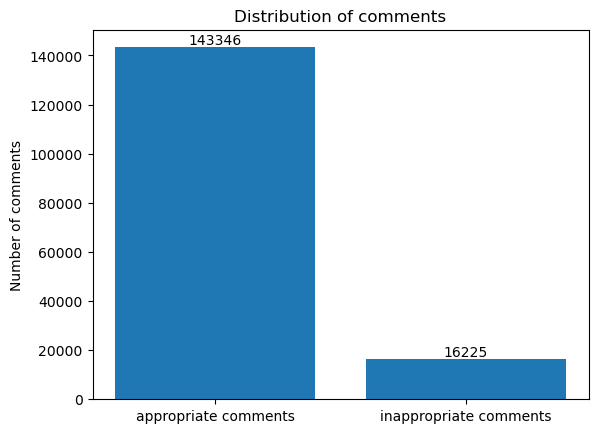

<IPython.core.display.Javascript object>

In [21]:
numbers = [appropriate, inappropriate]
labels = ['appropriate comments', 'inappropriate comments']

plt.bar(labels, numbers)
plt.title('Distribution of comments')
plt.xlabel('')
plt.ylabel('Number of comments')
ax = plt.gca()

for index, (label, value) in enumerate(zip(labels, numbers)):
    ax.text(index, value, str(int(value)), ha="center", va="bottom", fontsize=10)


plt.show()


In order to observe how different labels are distributed, a list of label values counts is created in ploted with the bar plot.

In [22]:
label_counts = []
for i in range(2, 8):
    values_df = train.iloc[:, i].value_counts()
    label_counts.append(values_df[1])

<IPython.core.display.Javascript object>

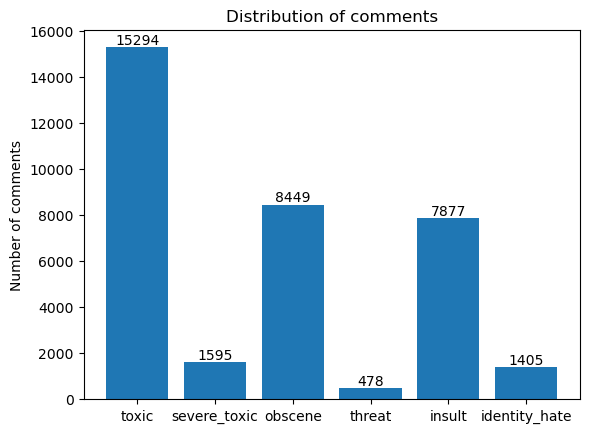

<IPython.core.display.Javascript object>

In [23]:
plt.bar(label_names, label_counts)
plt.title("Distribution of comments")
plt.xlabel("")
plt.ylabel("Number of comments")
ax = plt.gca()

for index, (label, value) in enumerate(zip(label_names, label_counts)):
    ax.text(index, value, str(int(value)), ha="center", va="bottom", fontsize=10)


plt.show()

It can be seen that the majority of inappropriate comments (15294 out of 16225) are labeled as toxic and some of them also get another label.

### Counting characters and words

The next step of the exploratory analysis of data is to count characters and words in comment text. For that purpose, the functions to plot the distribution of lenghts of characters and words are created and run on both train and test datasets. The subplots are presented bellow.

In [24]:


def plot_counts_hist(df: np.ndarray, bins: int, ax: plt.Axes, title: str) -> None:
    """
    Plot a histogram with counts on top of the bars.

    Parameters:
        df (np.ndarray): Data to be plotted.
        bins (int): Number of bins for the histogram.
        ax (plt.Axes): Matplotlib axis to plot on.
        title (str): Title for the plot.

    Returns:
        None
    """
    counts, bins, patches = ax.hist(
        df,
        color="green",
        bins=bins,
        edgecolor="black",
        alpha=0.7,
    )
    
    for count, x, patch in zip(counts, bins, patches):
        x_center = x + (bins[1] - bins[0]) / 2
        ax.text(x_center, count, str(int(count)), ha="center", va="bottom", fontsize=12)
        ax.text(
            x_center, count + 5, str(int(count)), ha="center", va="bottom", fontsize=12
        )
    
    ax.set_xlabel("Text Length")
    ax.set_ylabel("Frequency")
    ax.set_title(title)



<IPython.core.display.Javascript object>

##### Counts of characters in comments:

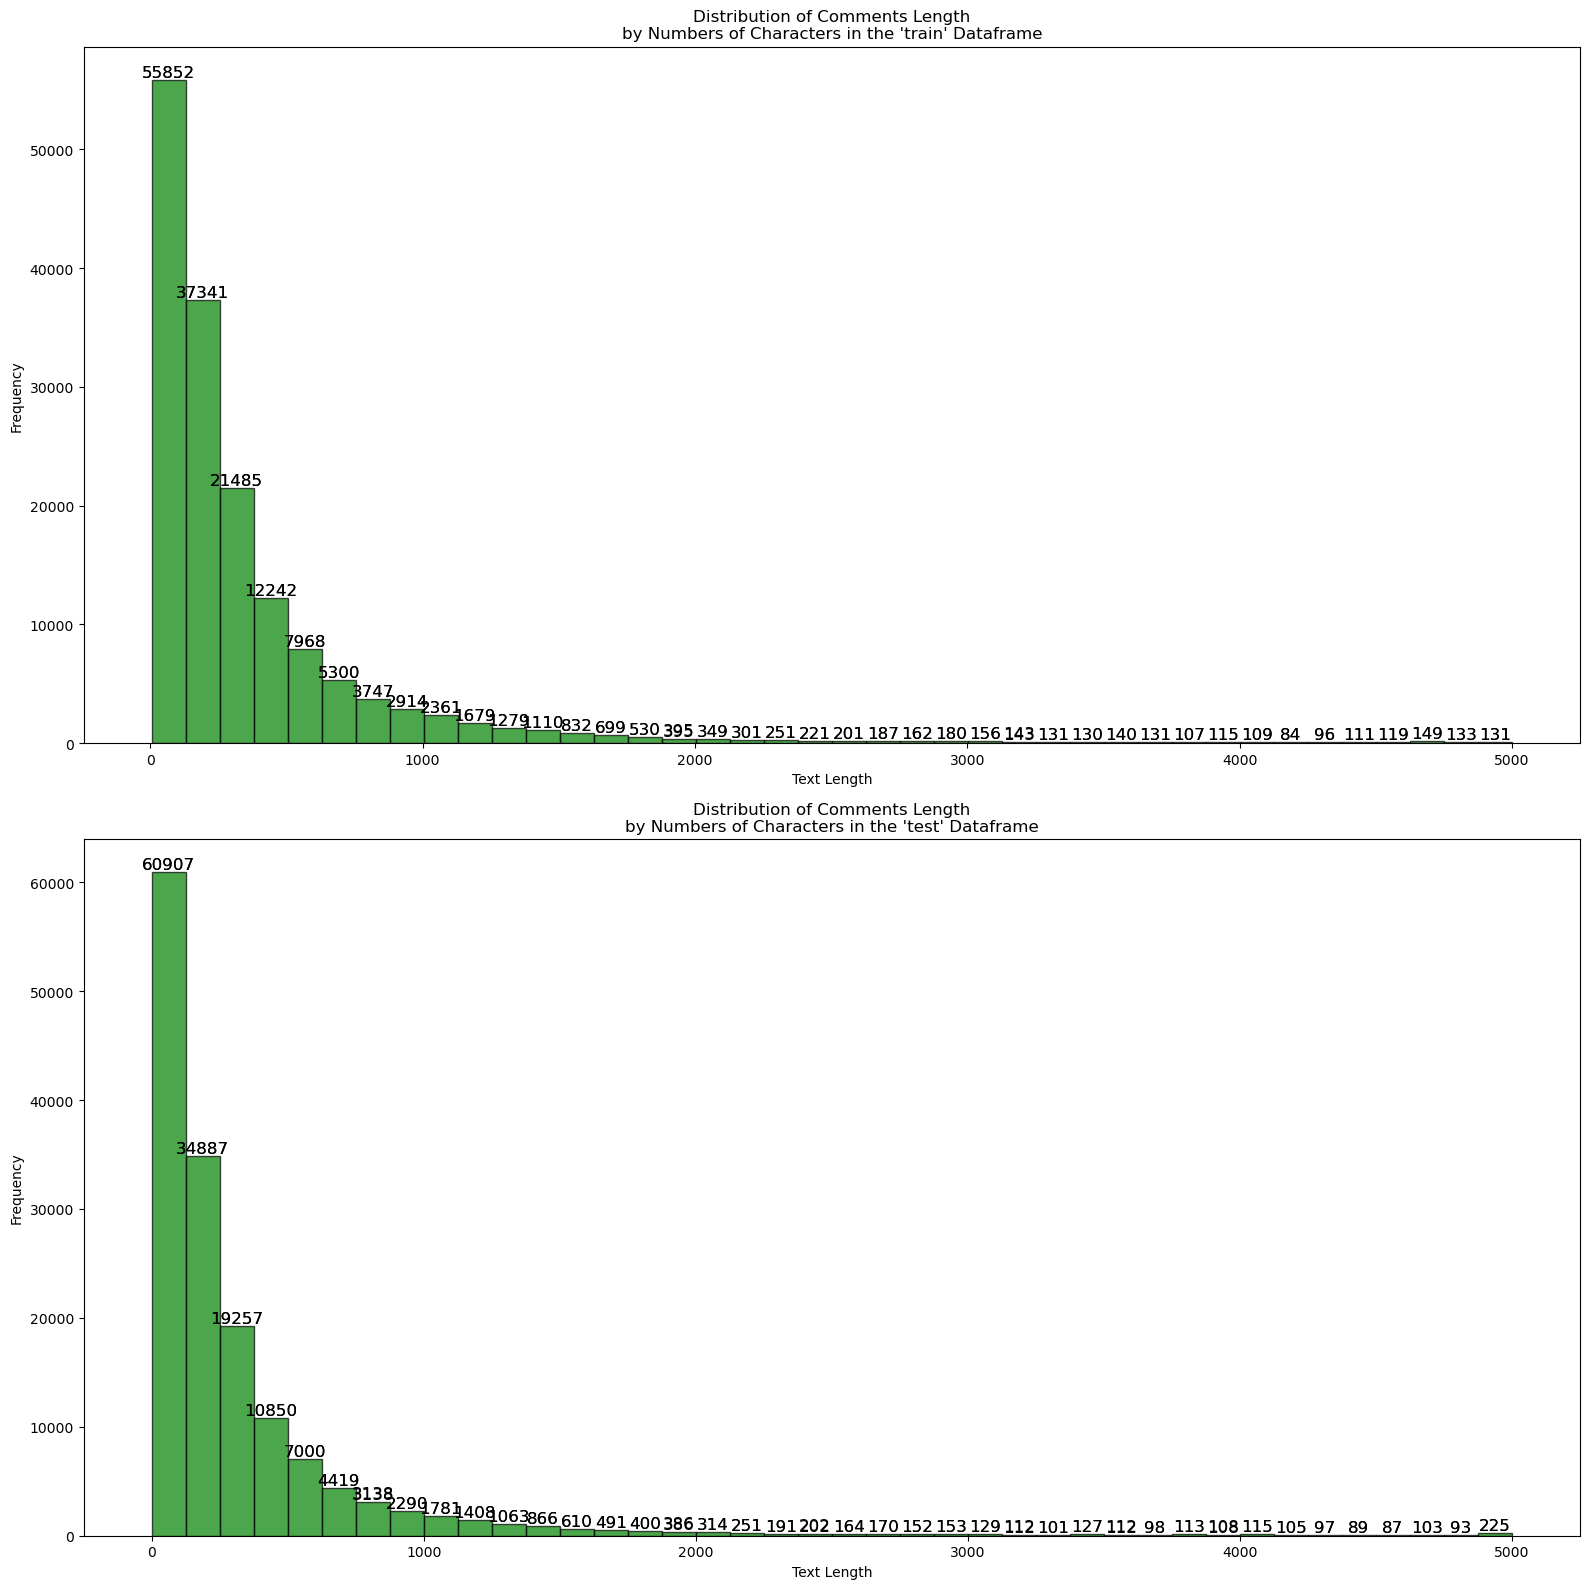

<IPython.core.display.Javascript object>

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 16))

plot_counts_hist(
    train["comment_text"].str.len(),
    bins=40,
    ax=ax1,
    title="Distribution of Comments Length\nby Numbers of Characters in the 'train' Dataframe",
)
plot_counts_hist(
    test["comment_text"].str.len(),
    bins=40,
    ax=ax2,
    title="Distribution of Comments Length\nby Numbers of Characters in the 'test' Dataframe",
)

plt.tight_layout()

plt.show()

##### Counts of words in comments: 

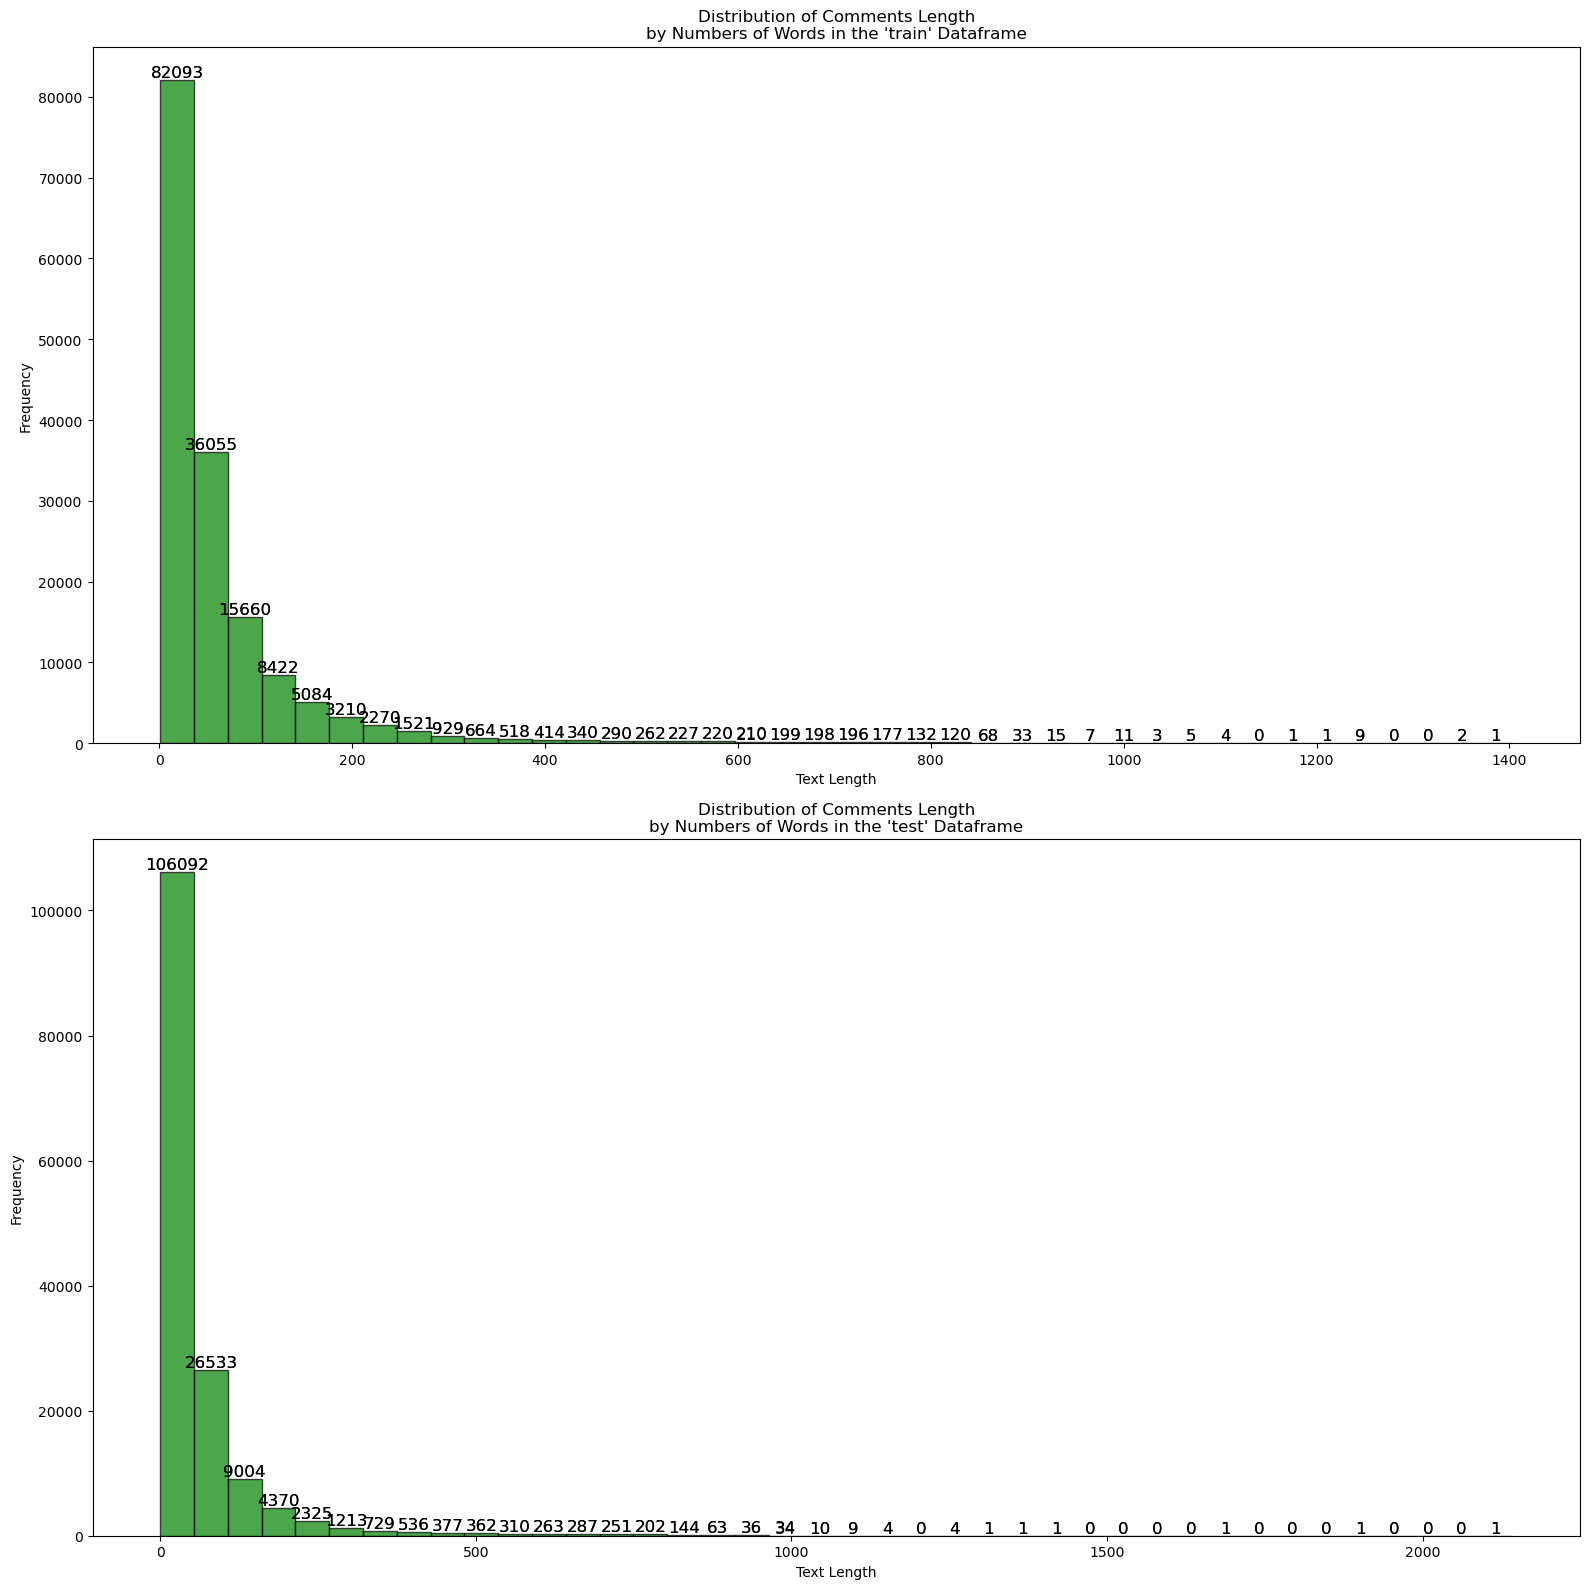

<IPython.core.display.Javascript object>

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 16))

plot_counts_hist(
    train["comment_text"].str.split().apply(len),
    bins=40,
    ax=ax1,
    title="Distribution of Comments Length\nby Numbers of Words in the 'train' Dataframe",
)
plot_counts_hist(
    test["comment_text"].str.split().apply(len),
    bins=40,
    ax=ax2,
    title="Distribution of Comments Length\nby Numbers of Words in the 'test' Dataframe",
)

plt.tight_layout()

plt.show()

It can be observed that there are comments which could be considered as outliers - they contain high numbers of characters and words. 

### Couting top stopwords and non-stopwords

Also, numbers stopwords and other words which are most often used are counted and presented in the plots. The code for calculating stopwords and the function for plotting stopwords was taken and adapted from here: https://app.neptune.ai/o/neptune-ai/org/eda-nlp-tools/n/1-3-top-stopwords-barchart-b953763c-3fea-4331-bff0-429411793e5f/5c0fca05-ba07-4564-a02e-c44b08bfb8cb


##### Stopwords

Stopwords are downloaded from the nltk library.

In [27]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

<IPython.core.display.Javascript object>

In [28]:
stop = set(stopwords.words("english"))

<IPython.core.display.Javascript object>

The corpus of all words in comment texts is created, occurences of words are counted and saved in the dictionaries. 

In [29]:
corpus_train = []
new_train = train["comment_text"].str.split()
new_train = new_train.values.tolist()
corpus_train = [word.lower() for i in new_train for word in i]
dic_train = defaultdict(int)
for word in corpus_train:
    if word in stop:
        dic_train[word] += 1


<IPython.core.display.Javascript object>

In [30]:
corpus_test = []
new_test = test["comment_text"].str.split()
new_test = new_test.values.tolist()
corpus_test = [word.lower() for i in new_test for word in i]


dic_test = defaultdict(int)
for word in corpus_test:
    if word in stop:
        dic_test[word] += 1

<IPython.core.display.Javascript object>

The function for plotting counts of occurences of stowords is created and the distributions of stopword counts are plotted.

In [31]:
def plot_top_stopwords_barchart(text: pd.Series, ax: plt.Axes, df: Any) -> None:
    """
    Plot a bar chart of the top stopwords in the text.

    Parameters:
        text (pd.Series): Pandas Series containing the text data.
        ax (plt.Axes): Matplotlib axis to plot on.
        df (Any): Dataframe associated with the text.

    Returns:
        None
    """
    stop = set(stopwords.words("english"))

    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    dic = defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]
    x, y = zip(*top)

    ax.bar(x, y)
    ax.set_xlabel("Stopwords")
    ax.set_ylabel("Frequency")
    ax.set_title(
        f"Top 10 Stopwords in the Comments Text: \
the {[name for name in globals() if globals()[name] is df][0]} Dataframe"
    )

<IPython.core.display.Javascript object>

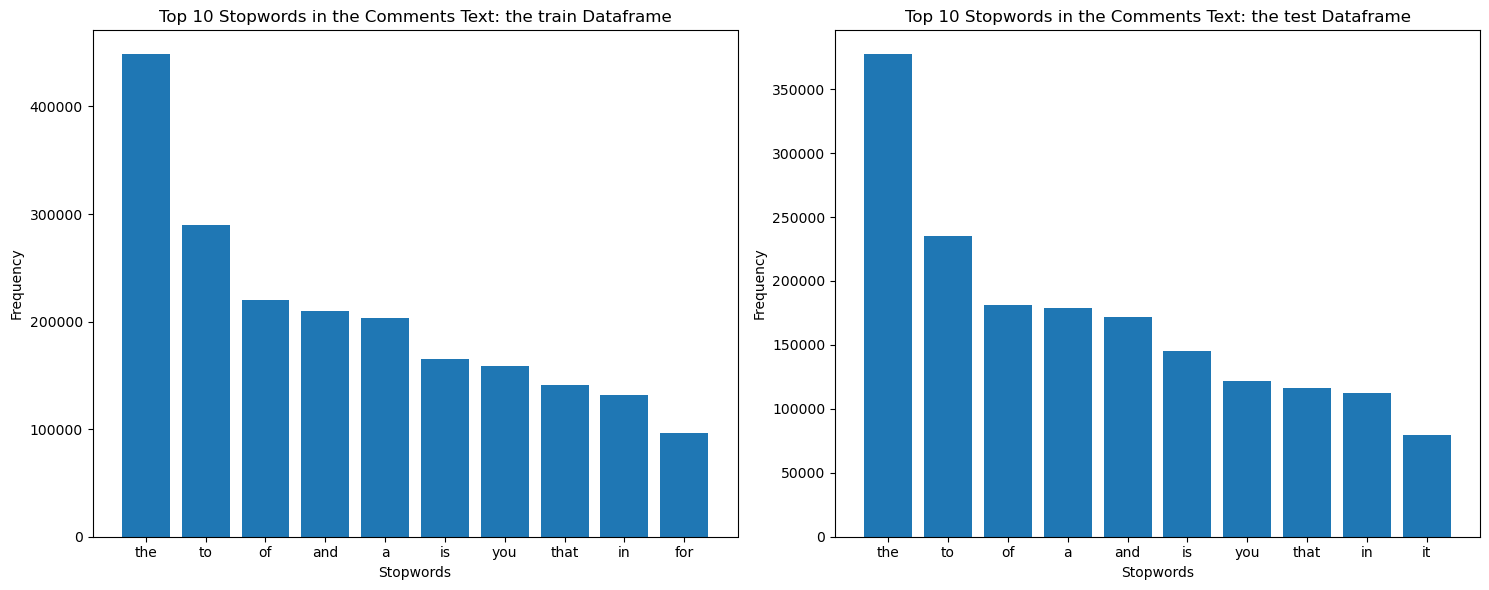

<IPython.core.display.Javascript object>

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

plot_top_stopwords_barchart(train["comment_text"], ax1, train)
plot_top_stopwords_barchart(test["comment_text"], ax2, test)

plt.tight_layout()
plt.show()

##### Non-stopwords

In the same way, occurences of non-stopwords are counted in both train and test datasets.

In [33]:
counter_train = Counter(corpus_train)
most_train = counter_train.most_common()


<IPython.core.display.Javascript object>

In [34]:
counter_test = Counter(corpus_test)
most_test = counter_test.most_common()

<IPython.core.display.Javascript object>

The function for plotting the non-stopwords is created and the distributions of the occurences of top non-stopwords are plotted.

In [35]:
def plot_top_non_stopwords_barchart(
    word_counts: List[Tuple[str, int]], ax: plt.Axes, title: str
) -> None:
    """
    Plot a bar chart of the top non-stopwords.

    Parameters:
        word_counts (List[Tuple[str, int]]): List of tuples containing word-count pairs.
        ax (plt.Axes): Matplotlib axis to plot on.
        title (str): Title for the plot.

    Returns:
        None
    """
    x, y = [], []
    for word, count in word_counts[:100]:
        if word not in stop:
            x.append(word)
            y.append(count)

    sns.barplot(x=y, y=x, ax=ax)
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Words")
    ax.set_title(title)

<IPython.core.display.Javascript object>

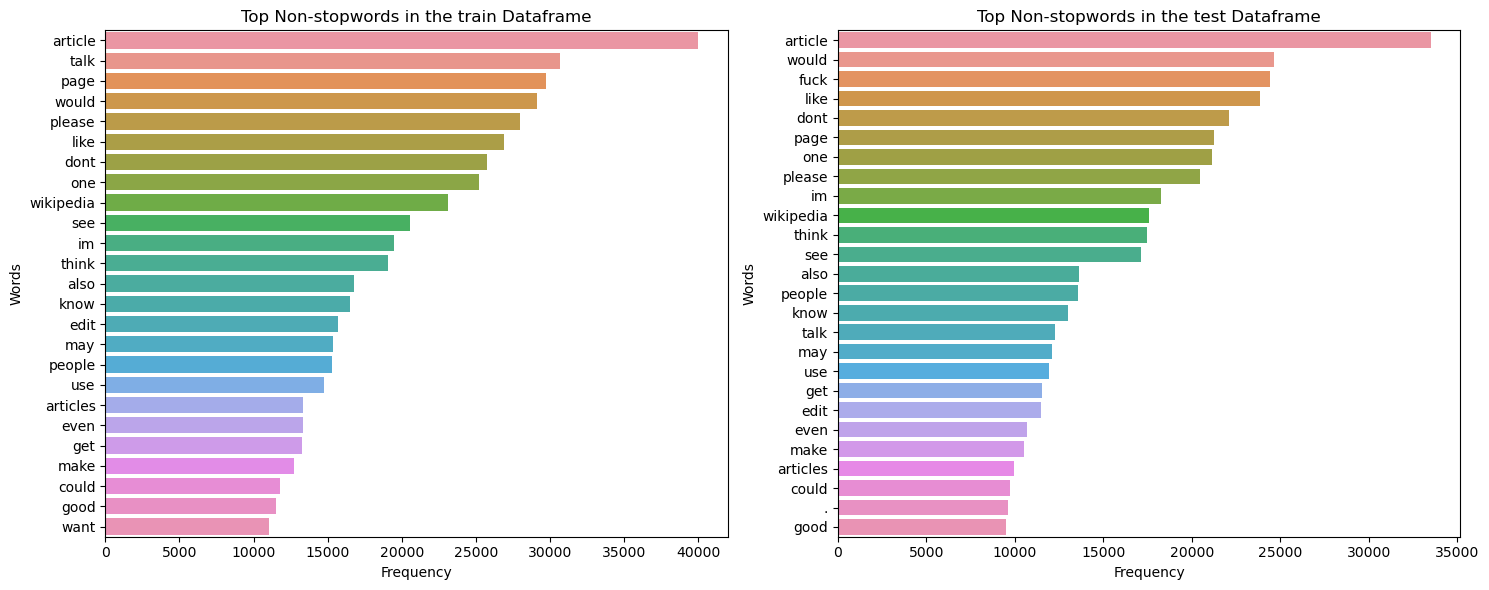

<IPython.core.display.Javascript object>

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

plot_top_non_stopwords_barchart(most_train, ax1, "Top Non-stopwords in the train Dataframe")
plot_top_non_stopwords_barchart(most_test, ax2, "Top Non-stopwords in the test Dataframe")

plt.tight_layout()
plt.show()


##### Toxic non-stopwords

Also, the words which are most common in the comments labeled as inappropriate are counted and the distributions of most common such words are plotted. 

In [37]:
corpus_train_inapr = []
new_train_inapr = train["comment_text"][
    (train["toxic"] == 1)
    | (train["severe_toxic"] == 1)
    | (train["obscene"] == 1)
    | (train["threat"] == 1)
    | (train["insult"] == 1)
    | (train["identity_hate"] == 1)
].str.split()
new_train_inapr = new_train_inapr.values.tolist()
corpus_train_inapr = [word.lower() for i in new_train_inapr for word in i]


<IPython.core.display.Javascript object>

In [38]:
counter_train_inapr = Counter(corpus_train_inapr)
most_train_inapr = counter_train_inapr.most_common()


<IPython.core.display.Javascript object>

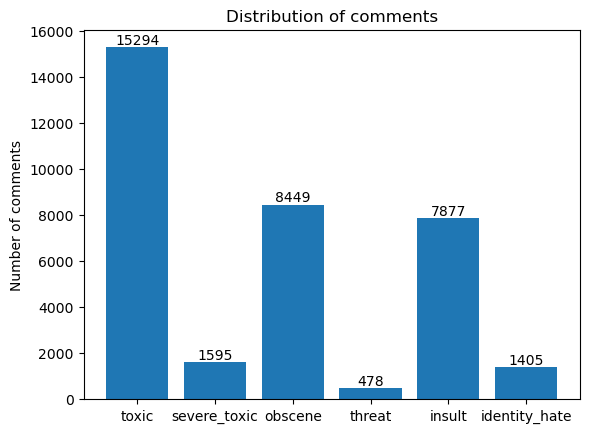

<IPython.core.display.Javascript object>

In [39]:
plt.bar(label_names, label_counts)
plt.title("Distribution of comments")
plt.xlabel("")
plt.ylabel("Number of comments")
ax = plt.gca()

for index, (label, value) in enumerate(zip(label_names, label_counts)):
    ax.text(index, value, str(int(value)), ha="center", va="bottom", fontsize=10)


plt.show()

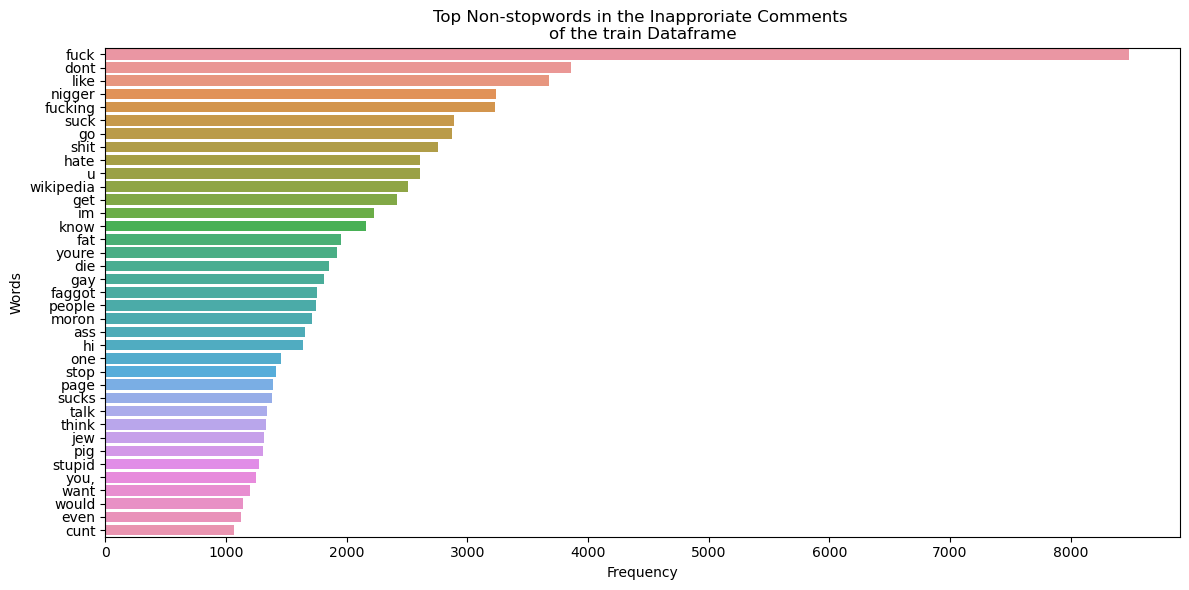

<IPython.core.display.Javascript object>

In [40]:
fig, ax = plt.subplots(figsize=(12, 6))

plot_top_non_stopwords_barchart(
    most_train_inapr,
    ax,
    "Top Non-stopwords in the Inapproriate Comments \nof the train Dataframe",
)

plt.tight_layout()
plt.show()

It can be observed that the words which are the most used in the inapproapriate comments are mainly curse words. 

### Counting ngrams

Next, bigrams of the comment text are analysed. The functions for getting top bigrams and plotting them are created, distributions of top bigrams are plotted. The functions were adapted from here: https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

In [41]:
def get_top_ngram(corpus: List[str], n: int = None) -> List[Tuple[str, int]]:
    """
    Returns the top n ngrams (sequences of n words) in a given corpus.

    Args:
        corpus (List[str]): A list of strings representing the corpus.
        n (int, optional): The length of the ngrams to be counted. Defaults to None.

    Returns:
        List[Tuple[str, int]]: A list of tuples containing the ngram and its frequency in the corpus, sorted in descending order by frequency.
    """

    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:10]

<IPython.core.display.Javascript object>

In [42]:
def plot_top_bigrams_barchart(top_bigrams: List[Tuple[str, int]], ax: plt.Axes, title: str) -> None:
    """
    Plot a bar chart of the top bigrams.

    Args:
        top_bigrams: A list of tuples containing the bigram and its frequency.
        ax: The axes on which to plot the bar chart.
        title: The title of the bar chart.
    """
    x, y = map(list, zip(*top_bigrams))
    sns.barplot(x=y, y=x, ax=ax)

    ax.set_xlabel("Frequency")
    ax.set_ylabel("Words")
    ax.set_title(title)


<IPython.core.display.Javascript object>

In [43]:
top_bigrams_train = get_top_ngram(corpus_train, 2)[:10]
top_bigrams_test = get_top_ngram(corpus_test, 2)[:10]

<IPython.core.display.Javascript object>

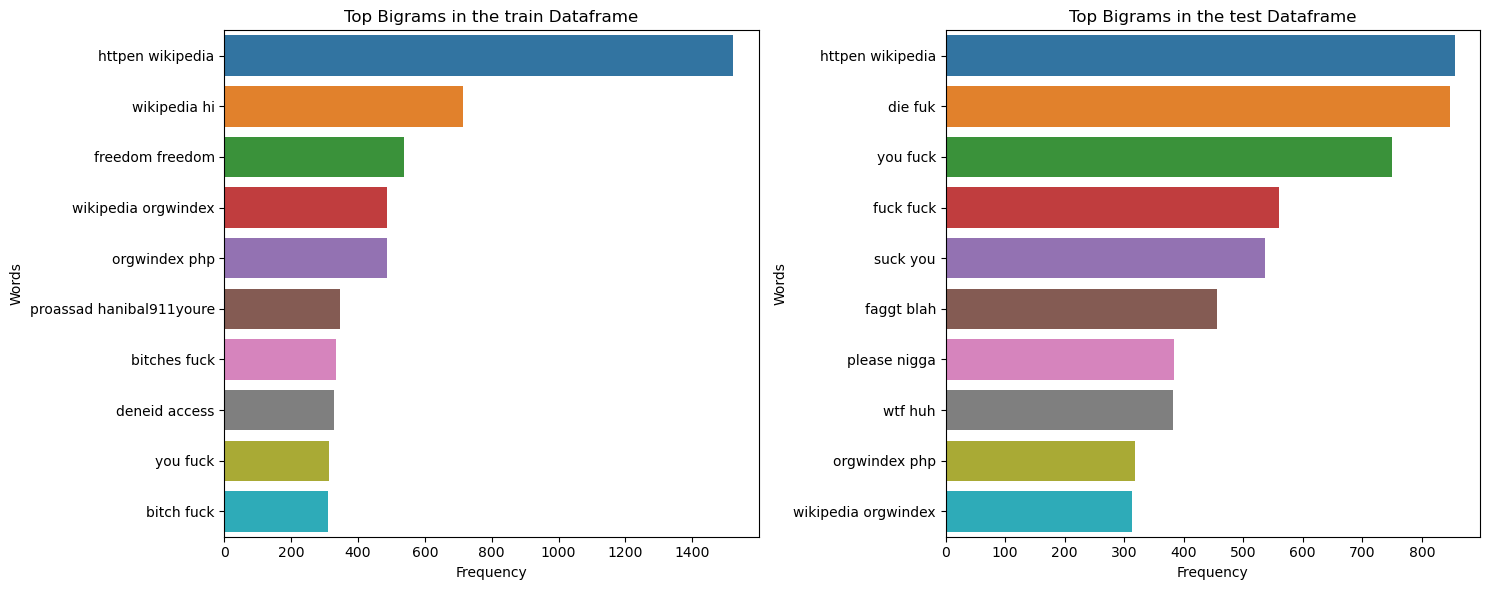

<IPython.core.display.Javascript object>

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

plot_top_bigrams_barchart(top_bigrams_train, ax1, "Top Bigrams in the train Dataframe")
plot_top_bigrams_barchart(top_bigrams_test, ax2, "Top Bigrams in the test Dataframe")

plt.tight_layout()
plt.show()

##### Top bigrams in the inapproapriate comments

Also, bigrams of the inappropriate comments are counted. It can be observed that top bigrams in these comments are different from the top comments in the total dataset, they mainly ontain curse words.

In [45]:
top_bigrams_train_inapr = get_top_ngram(corpus_train_inapr, 2)[:10]


<IPython.core.display.Javascript object>

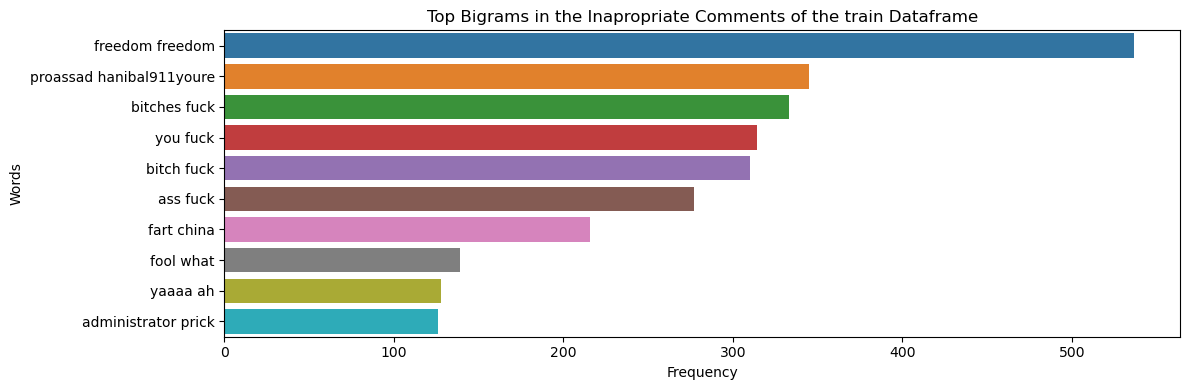

<IPython.core.display.Javascript object>

In [46]:
fig, ax = plt.subplots(figsize=(12, 4))

plot_top_bigrams_barchart(
    top_bigrams_train_inapr,
    ax,
    "Top Bigrams in the Inapropriate Comments of the train Dataframe",
)

plt.tight_layout()
plt.show()

### LDA analyis

Latent Dirichlet Allocation (LDA) is an method used for topic modeling in the text. Each document is represented by the distribution of topics and each topic is represented by the distribution of words. The functions for preprocessing comments and the LDA analysis are adapted from here: https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

In [47]:
nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /Users/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

<IPython.core.display.Javascript object>

In [48]:
def preprocess_comments(df: pd.DataFrame) -> list:
    """
    Preprocesses the comments in a given dataframe by removing stop words, 
    lemmatizing words, and tokenizing the comments.

    Parameters:
        df (pd.DataFrame): A dataframe containing comments to be preprocessed.

    Returns:
        corpus (list): A list of tokenized and lemmatized comments.

    """
    corpus = []
    stem = PorterStemmer()
    lem = WordNetLemmatizer()
    for comment in df:
        words = [w for w in word_tokenize(comment) if (w not in stop)]

        words = [lem.lemmatize(w) for w in words if len(w) > 2]

        corpus.append(words)
    return corpus


<IPython.core.display.Javascript object>

In [49]:
corpus_train_prep = preprocess_comments(train["comment_text"])
corpus_test_prep = preprocess_comments(test["comment_text"])

<IPython.core.display.Javascript object>

In [50]:
dic_train = gensim.corpora.Dictionary(corpus_train_prep)
bow_corpus_train = [dic_train.doc2bow(doc) for doc in corpus_train_prep]
dic_test = gensim.corpora.Dictionary(corpus_test_prep)
bow_corpus_test = [dic_test.doc2bow(doc) for doc in corpus_test_prep]

<IPython.core.display.Javascript object>

In [51]:
lda_model_train = gensim.models.LdaMulticore(
    bow_corpus_train, num_topics=4, id2word=dic_train, passes=10, workers=1
)
lda_output_train = lda_model_train.show_topics()

<IPython.core.display.Javascript object>

In [52]:
lda_model_test = gensim.models.LdaMulticore(
    bow_corpus_test, num_topics=4, id2word=dic_test, passes=10, workers=1
)
lda_output_test = lda_model_test.show_topics()

<IPython.core.display.Javascript object>

The top words in five topics in both train and test dataframes were identified and plotted. 

In [53]:
def visualize_lda_topics(lda_output: List[Tuple[int, str]]) -> None:
    """
    Visualize the topics generated by LDA (Latent Dirichlet Allocation) algorithm.

    Args:
        lda_output (list of tuples): The output of LDA algorithm, where each tuple
            contains the topic ID and the list of terms and their weights.

    Returns:
        None. The function plots a bar chart for each topic, showing the top 10 terms
        with the highest weights.

    Raises:
        TypeError: If the input argument is not a list of tuples.

    """
    if not isinstance(lda_output, list):
        raise TypeError("The input argument must be a list of tuples.")

    for topic_id, topic_terms in lda_output:
        terms_weights = [
            term_weight.split("*") for term_weight in topic_terms.split(" + ")
        ]
        terms, weights = zip(
            *[(term.strip('"'), float(weight)) for weight, term in terms_weights]
        )

        plt.figure(figsize=(10, 6))
        plt.barh(terms[:10][::-1], weights[:10][::-1], color="skyblue")
        plt.xlabel("Term Weight")
        plt.ylabel("Term")
        plt.title(f"Topic {topic_id + 1}")
        plt.gca().invert_yaxis()
        plt.show()

<IPython.core.display.Javascript object>

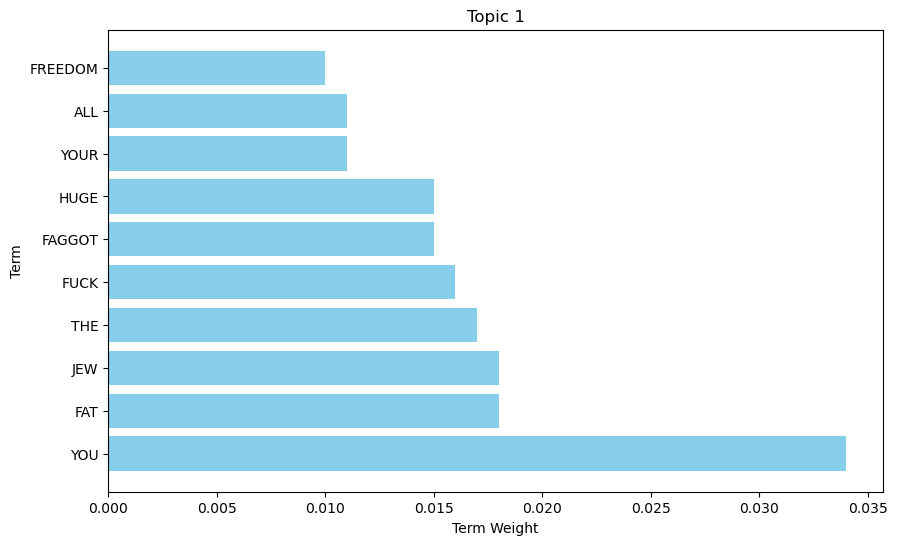

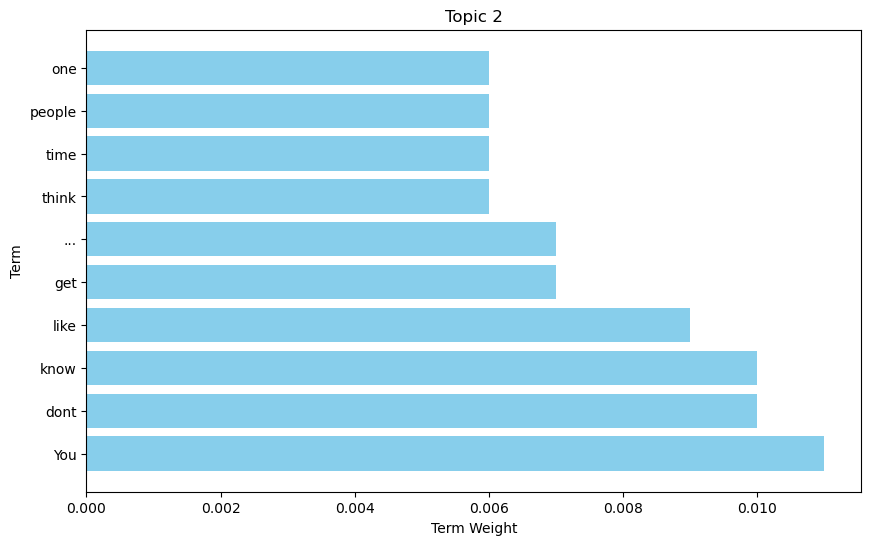

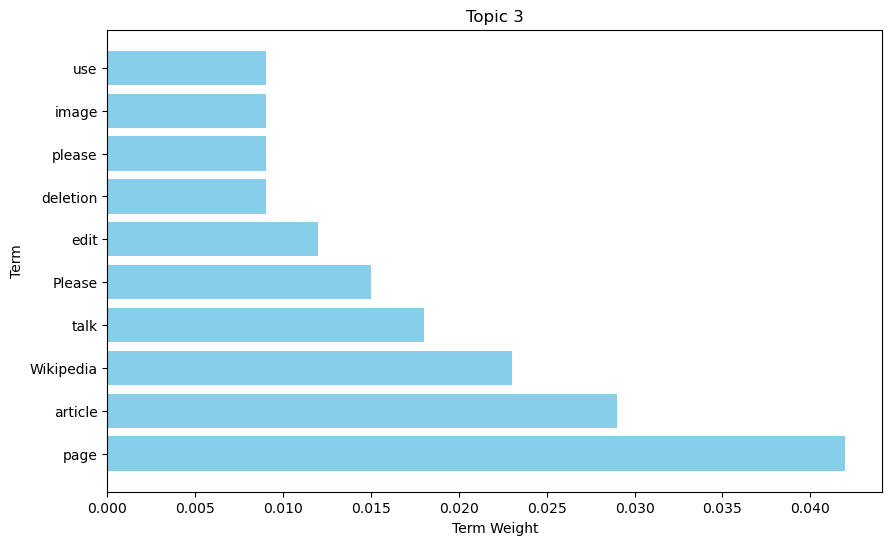

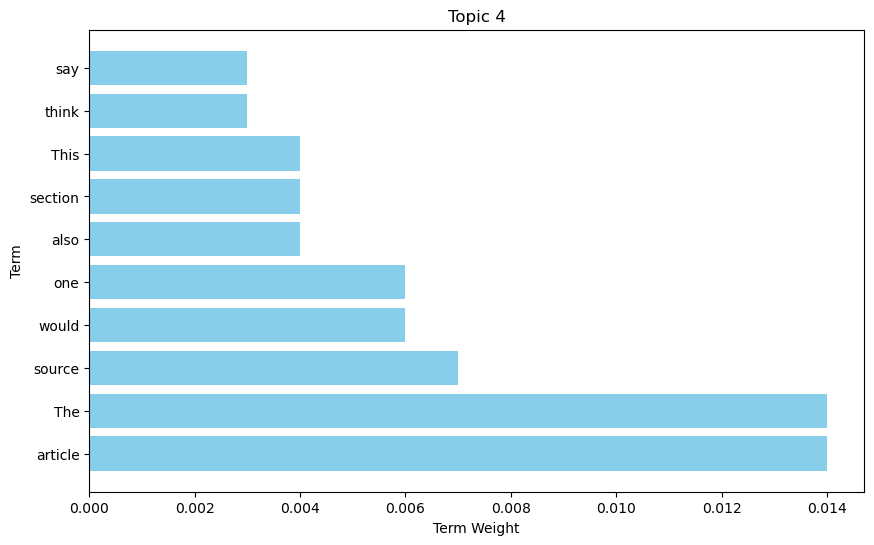

<IPython.core.display.Javascript object>

In [54]:
visualize_lda_topics(lda_output_train)

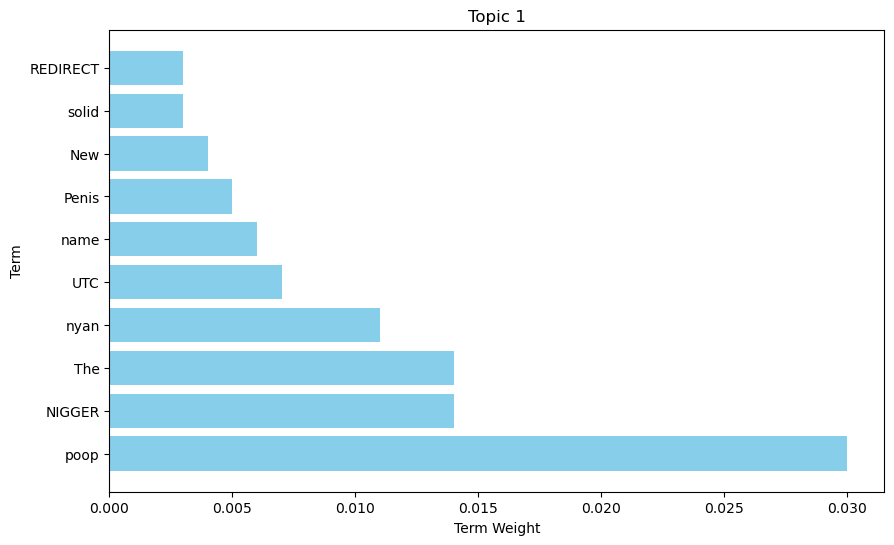

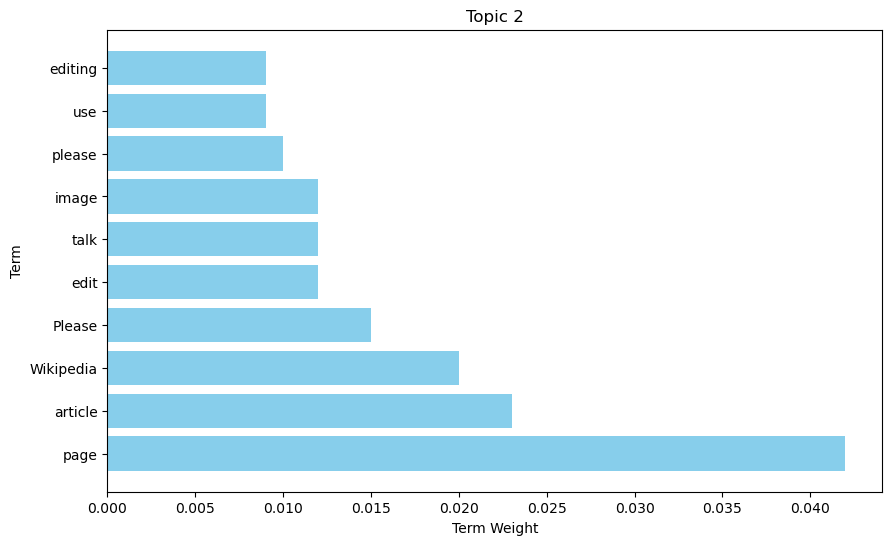

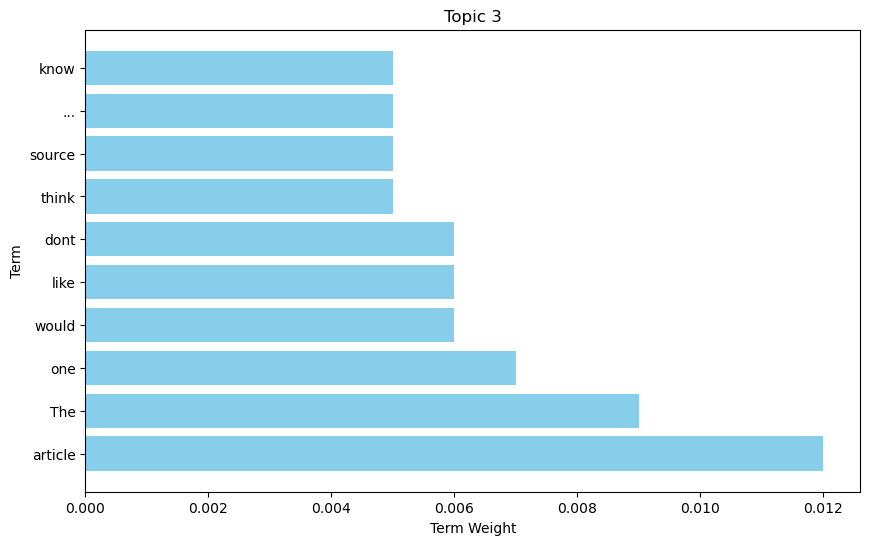

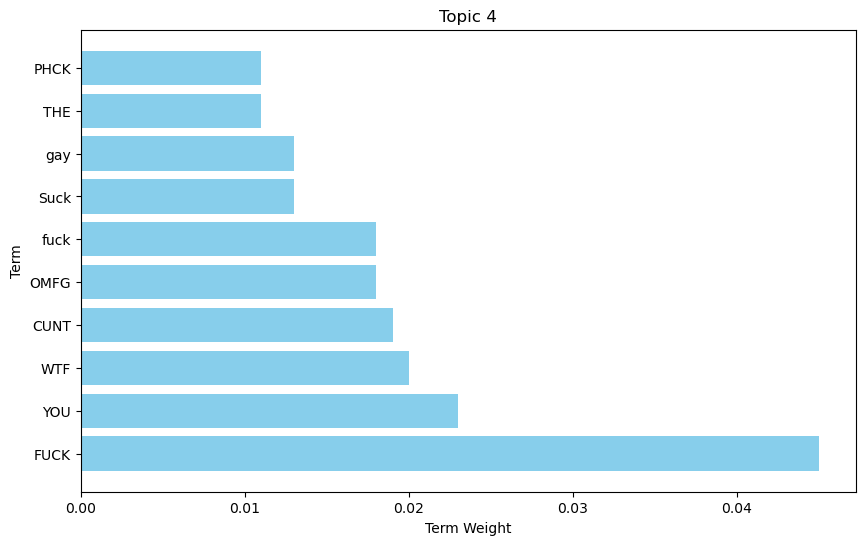

<IPython.core.display.Javascript object>

In [55]:
visualize_lda_topics(lda_output_test)

It can be observed that the fourth topic in both datasets includes inappropriate words as the most used. 

##### LDA for the inaproriapriate comments

In [56]:
corpus_train_inapr = preprocess_comments(train["comment_text"][
    (train["toxic"] == 1)
    | (train["severe_toxic"] == 1)
    | (train["obscene"] == 1)
    | (train["threat"] == 1)
    | (train["insult"] == 1)
    | (train["identity_hate"] == 1)
])


<IPython.core.display.Javascript object>

In [57]:
dic_train_inapr = gensim.corpora.Dictionary(corpus_train_inapr)
bow_corpus_train_inapr = [dic_train_inapr.doc2bow(doc) for doc in corpus_train_inapr]

<IPython.core.display.Javascript object>

In [58]:
lda_model_train_inapr = gensim.models.LdaMulticore(
    bow_corpus_train_inapr, num_topics=4, id2word=dic_train, passes=10, workers=1
)
lda_output_train_inapr = lda_model_train_inapr.show_topics()

<IPython.core.display.Javascript object>

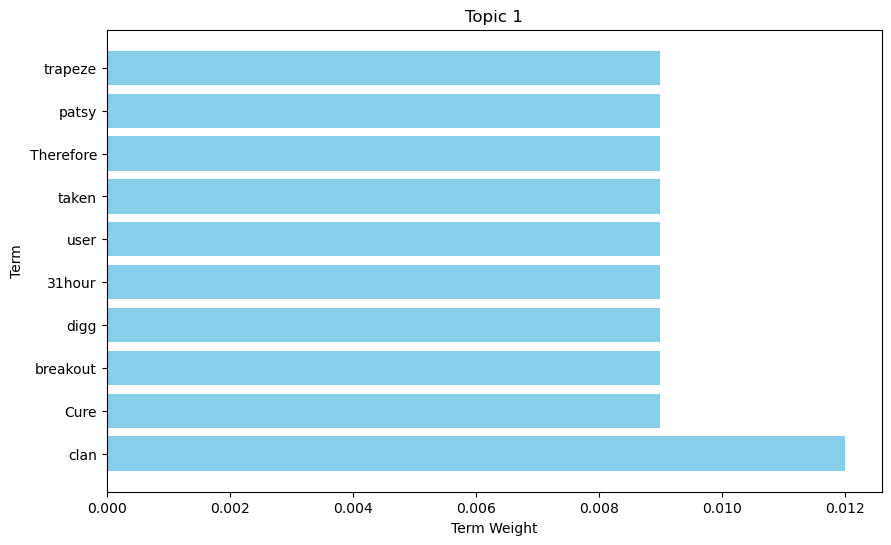

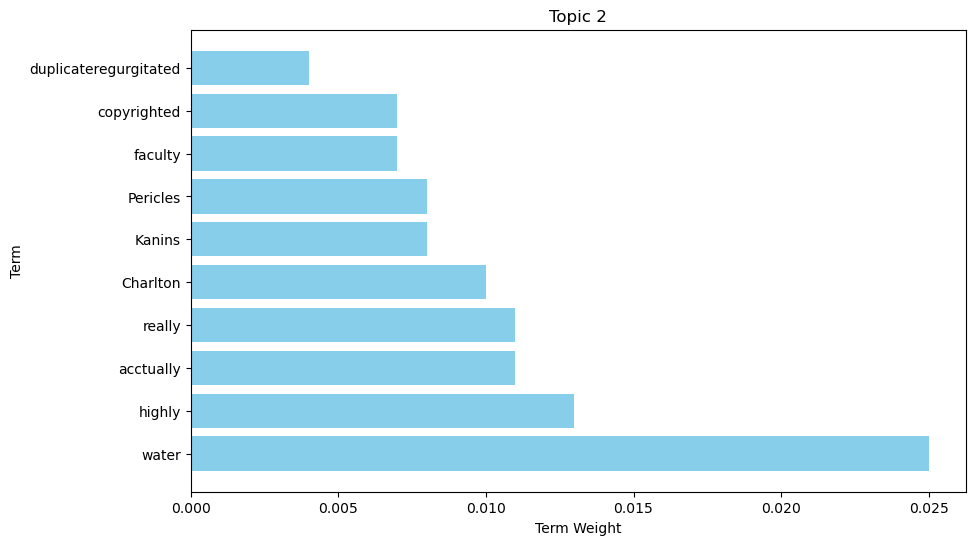

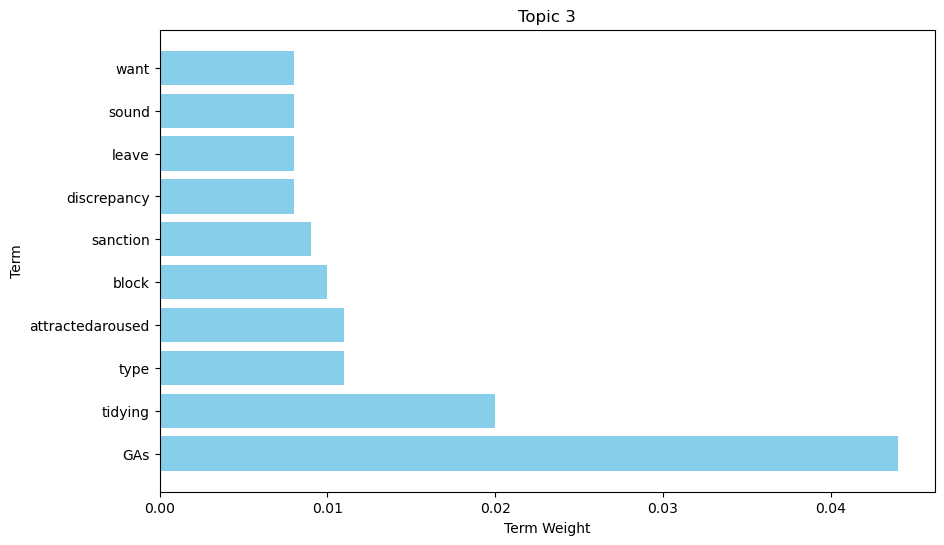

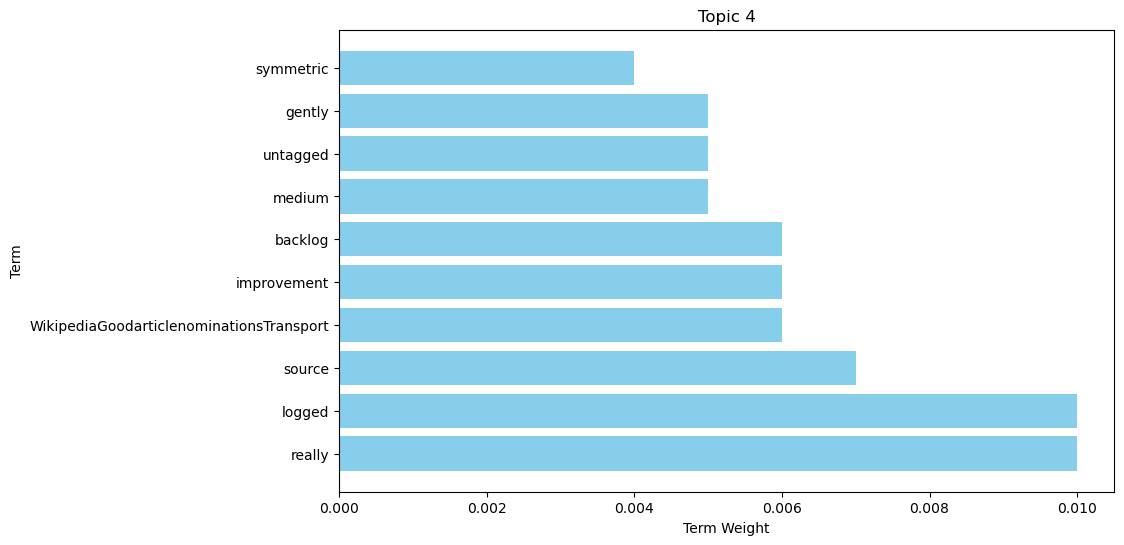

<IPython.core.display.Javascript object>

In [59]:
visualize_lda_topics(lda_output_train_inapr)

It can be observed that the curse words are not these which distinguish one topic from another. It might me concluded that curse words are equally present in comments of all four topics.

### Sentiment analysis

Next, sentiments of comments are analysed by using the TextBlob library. The functions for identifying and plotting polarity of comments are created and run on both train and test datarames. 

In [60]:
def polarity(text: str) -> float:
    """
    Calculates the polarity of a given text using the TextBlob library.

    Args:
        text (str): The text to be analyzed.

    Returns:
        float: The polarity of the text, which is a value between -1 and 1.
    """
    return TextBlob(text).sentiment.polarity

<IPython.core.display.Javascript object>

In [61]:
train["polarity_score"] = train["comment_text"].apply(lambda x: polarity(x))
test["polarity_score"] =test["comment_text"].apply(lambda x: polarity(x))


<IPython.core.display.Javascript object>

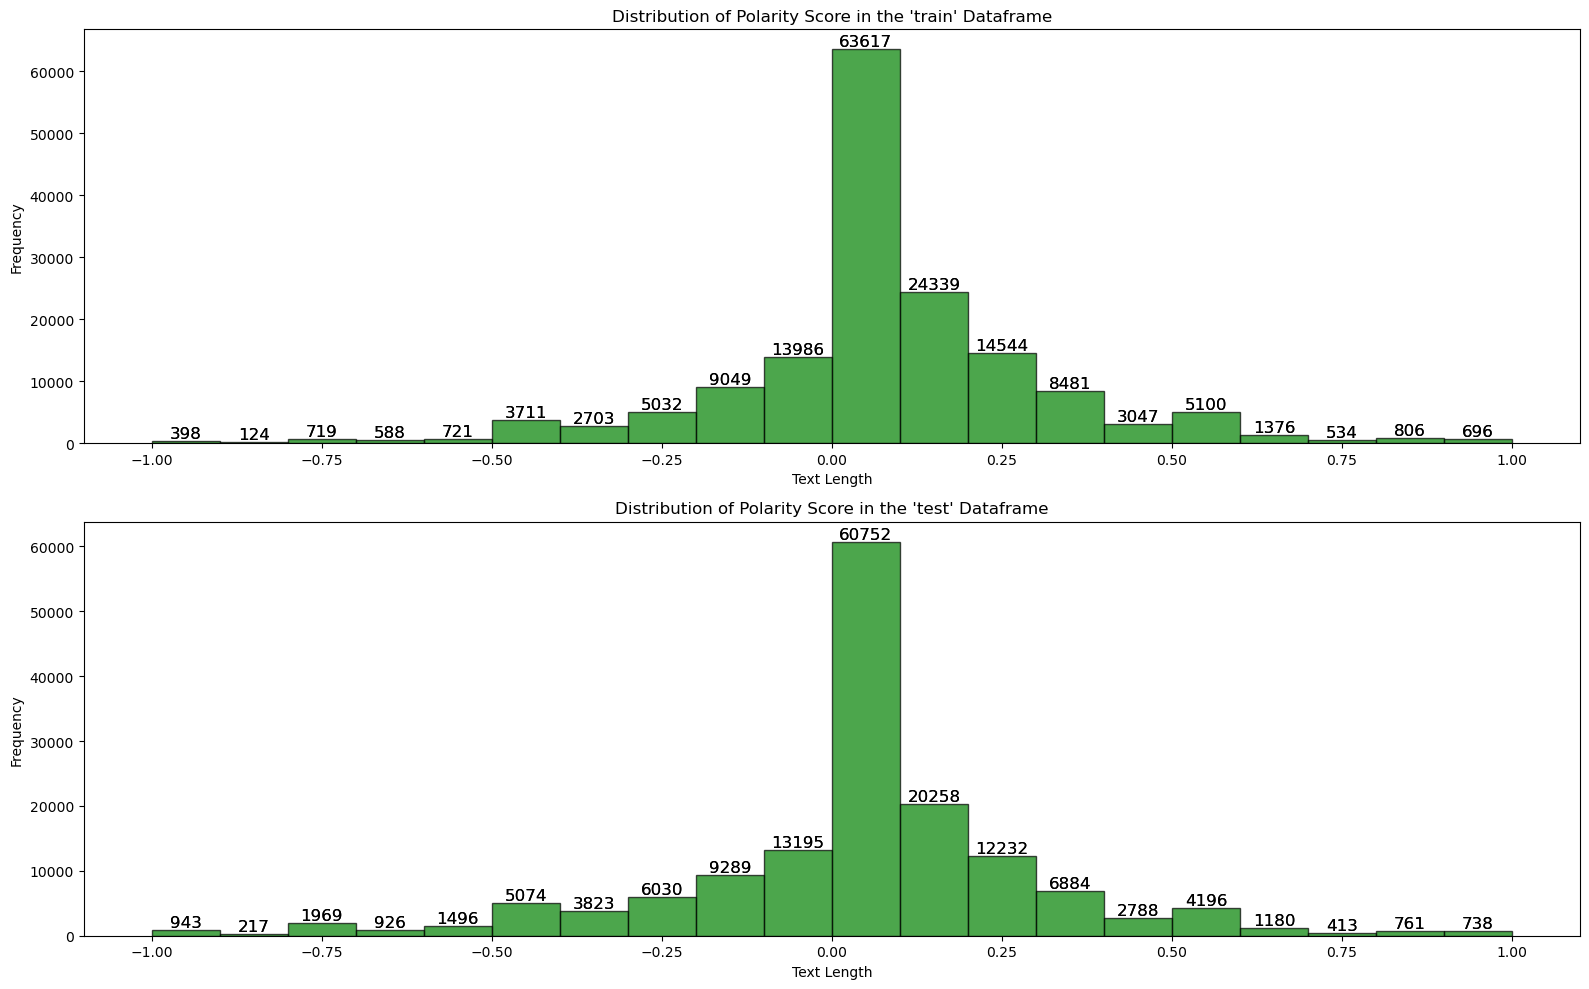

<IPython.core.display.Javascript object>

In [62]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

plot_counts_hist(
    train["polarity_score"],
    bins=20,
    ax=ax1,
    title="Distribution of Polarity Score in the 'train' Dataframe",
)
plot_counts_hist(
    test["polarity_score"],
    bins=20,
    ax=ax2,
    title="Distribution of Polarity Score in the 'test' Dataframe",
)

plt.tight_layout()

plt.show()

The functions for grouping polarity in to positive, neutral and negative grours and plotting the distributions of groups are created and run.

In [63]:
def sentiment(x: int) -> str:
    """
    Returns the sentiment of a given number.

    Parameters:
    x (int): The number to be evaluated.

    Returns:
    str: The sentiment of the given number. Can be 'neg' (negative), 'neu' (neutral), or 'pos' (positive).
    """
    if x < 0:
        return "neg"
    elif x == 0:
        return "neu"
    else:
        return "pos"

<IPython.core.display.Javascript object>

In [64]:
train['polarity']=train['polarity_score'].map(lambda x: sentiment(x))
test['polarity']=test['polarity_score'].map(lambda x: sentiment(x))


<IPython.core.display.Javascript object>

In [65]:
def plot_counts_bar(df: pd.DataFrame, ax: plt.Axes, title: str) -> None:
    """
    Plots a bar graph of the counts in a given dataframe.

    Parameters:
        df (pd.DataFrame): The dataframe containing the counts to be plotted.
        ax (plt.Axes): The axes to plot the bar graph on.
        title (str): The title of the plot.

    Returns:
        None: This function does not return anything, it only plots the graph.

    """
    ax.bar(df.index, df.values, color="blue", alpha=0.7)

    ax.set_xlabel("")
    ax.set_ylabel("Frequency")
    ax.set_title(title)

    for x, y in zip(df.index, df.values):
        ax.text(x, y, str(int(y)), ha="center", va="bottom", fontsize=10)

<IPython.core.display.Javascript object>

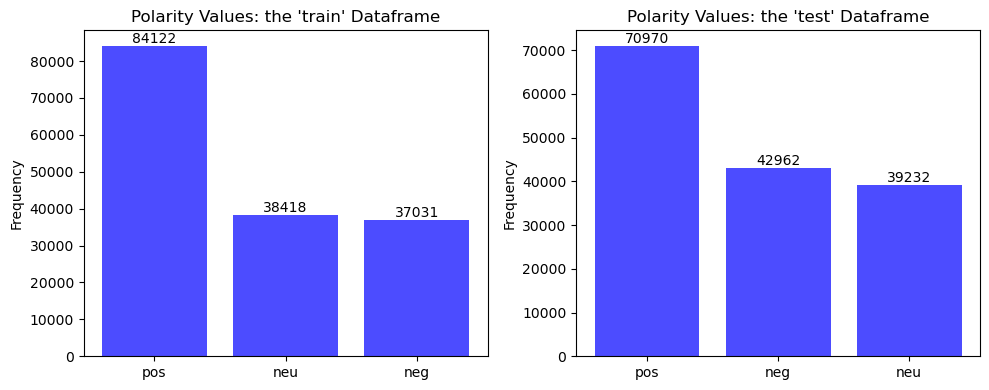

<IPython.core.display.Javascript object>

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

plot_counts_bar(
    train["polarity"].value_counts(),
    ax=ax1,
    title="Polarity Values: the 'train' Dataframe",
)
plot_counts_bar(
    test["polarity"].value_counts(),
    ax=ax2,
    title="Polarity Values: the 'test' Dataframe",
)

plt.tight_layout()

plt.show()

##### Sentiment analysis of inappropriate comments

Also, it is interesting to observe what the sentiment of inapropriate comments is most common. It could be hypothesized that inappropriate comments mainly express negative sentiments. The functions are run on the filtered data of inapropriate comments. Outputs are presented bellow. 

In [67]:
train_inapr = train.copy()

<IPython.core.display.Javascript object>

In [68]:
train_inapr["polarity_score"] = train_inapr["comment_text"][
    (train_inapr["toxic"] == 1)
    | (train_inapr["severe_toxic"] == 1)
    | (train_inapr["obscene"] == 1)
    | (train_inapr["threat"] == 1)
    | (train_inapr["insult"] == 1)
    | (train_inapr["identity_hate"] == 1)
].apply(lambda x: polarity(x))

<IPython.core.display.Javascript object>

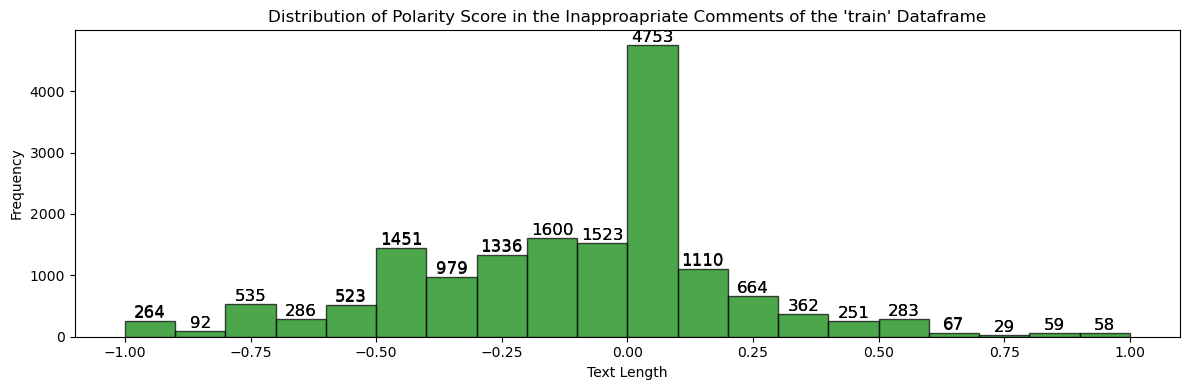

<IPython.core.display.Javascript object>

In [69]:
fig, ax = plt.subplots(figsize=(12, 4))

plot_counts_hist(
    train_inapr["polarity_score"],
    bins=20,
    ax=ax,
    title="Distribution of Polarity Score in the Inapproapriate Comments of the 'train' Dataframe",
)

plt.tight_layout()

plt.show()

In [70]:
train_inapr["polarity"] = train_inapr["polarity_score"][
    (train_inapr["toxic"] == 1)
    | (train_inapr["severe_toxic"] == 1)
    | (train_inapr["obscene"] == 1)
    | (train_inapr["threat"] == 1)
    | (train_inapr["insult"] == 1)
    | (train_inapr["identity_hate"] == 1)
].map(lambda x: sentiment(x))

<IPython.core.display.Javascript object>

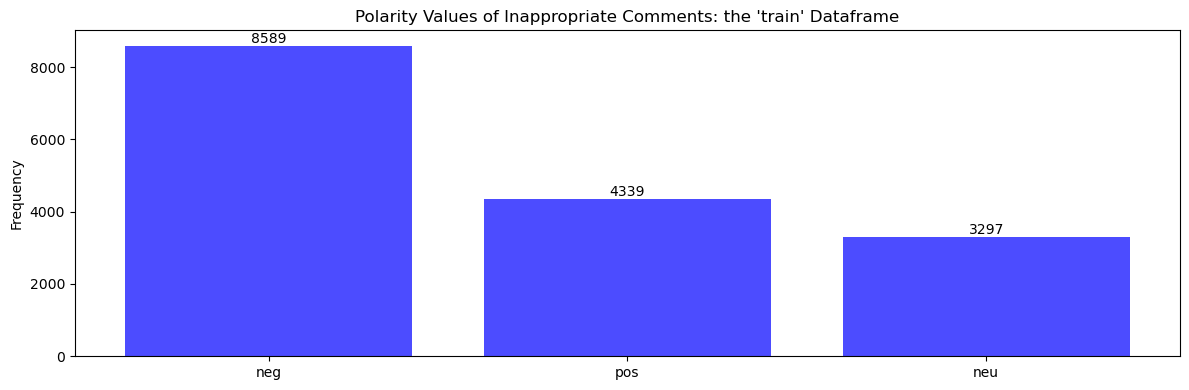

<IPython.core.display.Javascript object>

In [71]:
fig, ax = plt.subplots(figsize=(12, 4))

plot_counts_bar(
    train_inapr["polarity"].value_counts(),
    ax=ax,
    title="Polarity Values of Inappropriate Comments: the 'train' Dataframe",
)

plt.tight_layout()

plt.show()

As it was hypothesized, the majority of inappropriate comments are classified as expressing negative sentiment.

### wordcloud analysis

Finally, worldcloud analysis of the train and test datasets was conducted by using the WordCloud library. Words which are most often used in the datasets are presented in the worldcloud maps. 

In [72]:
stopwords = set(STOPWORDS)

<IPython.core.display.Javascript object>

In [73]:
def show_wordcloud(data: str) -> None:
    """
    Displays a word cloud of the given data.

    Parameters:
        data (str): The data to be used for creating the word cloud.

    Returns:
        None: Displays the word cloud as a matplotlib figure.

    """

    # Create a WordCloud object with specified settings
    wordcloud = WordCloud(
        background_color="white",
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1,
    )

    # Generate the word cloud using the given data
    wordcloud = wordcloud.generate(str(data))

    # Create a figure with specified size
    fig = plt.figure(1, figsize=(12, 12))

    # Turn off the axes
    plt.axis("off")

    # Display the word cloud as an image
    plt.imshow(wordcloud)

    # Show the figure
    plt.show()

<IPython.core.display.Javascript object>

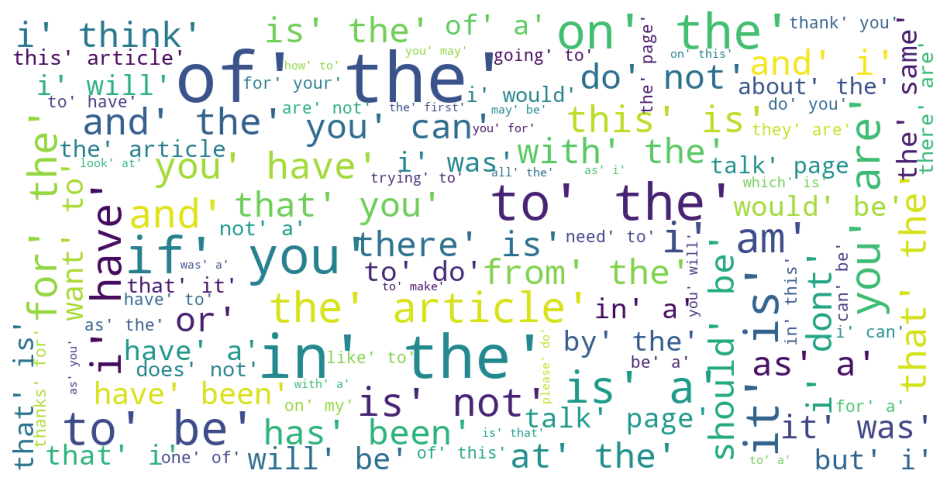

<IPython.core.display.Javascript object>

In [74]:
show_wordcloud(corpus_train)

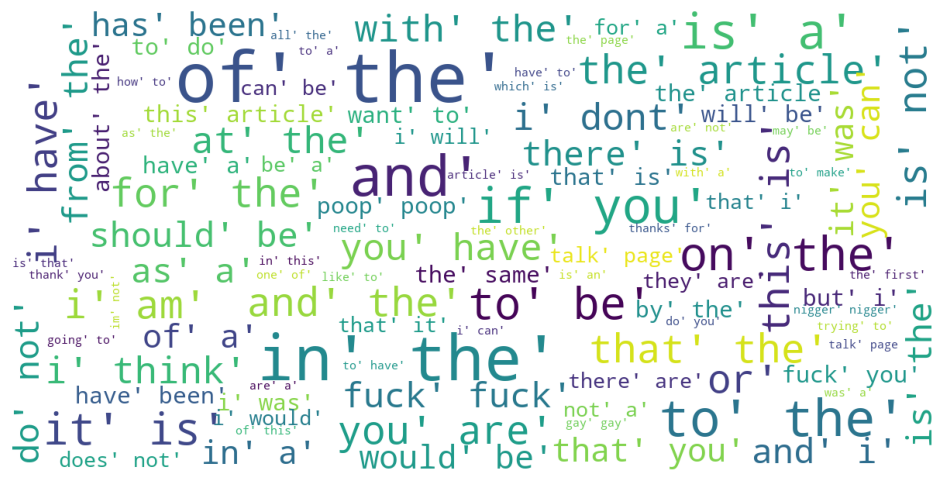

<IPython.core.display.Javascript object>

In [75]:
show_wordcloud(corpus_test)

##### wordcloud analysis of inappropriate comments

Also, wordcloud map is created for inapproapriate comments. 

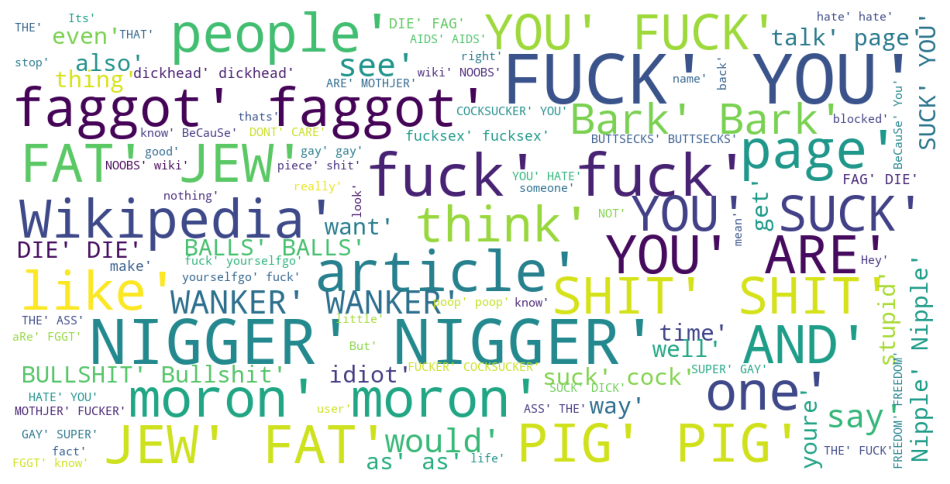

<IPython.core.display.Javascript object>

In [76]:
show_wordcloud(corpus_train_inapr)

It can be observed that the most used words in inappropriate comments are curse and hate speech words.

## 2. Modelling


In this part the process and results of transfer learning for the multi-label classification of Wikipedia comments are presented. The pretained model of multi-label classification classification - Distilbert model - is used for building models which would be able to correctly predict labels of inapropriate comments.


### Splitting the dataset into train and validation datasets


The train dataframe is split into train (70 percent) and validation (30 percent) datasets. The test dataset which does not contain labels is supposed to be used for prediction purposes after the classification model is trained. 


In [77]:
df_train, df_val = train_test_split(train, test_size=0.3, random_state=13)


<IPython.core.display.Javascript object>

In [78]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

<IPython.core.display.Javascript object>

The train and validation datasets are tokenized and loaded as objects of a CommmentsDataset class created on the basis of a pytorch dataset class (see a separate Python file). 

In [79]:
train_dataset = WikipediaCommentDataset(df_train, labels_available=True)
val_dataset = WikipediaCommentDataset(df_val, labels_available=True)

Loading the tokenizer from the `special_tokens_map.json` and the `added_tokens.json` will be removed in `transformers 5`,  it is kept for forward compatibility, but it is recommended to update your `tokenizer_config.json` by uploading it again. You will see the new `added_tokens_decoder` attribute that will store the relevant information.


<IPython.core.display.Javascript object>

In [80]:
test_dataset = WikipediaCommentDataset(test, labels_available=False)

<IPython.core.display.Javascript object>

The class has methods of getting dataset length and ittems. Examples of their use are presented bellow.

In [81]:
len(
    train_dataset,
)

111699

<IPython.core.display.Javascript object>

In [82]:
test_dataset[8]

{'input_ids': tensor([  101,  2069,  1037,  7966,  2064,  2903,  1999,  2107,  3616,  1012,
          1996,  6149,  2193,  3658,  2090,  2184,  2199,  2000,  2321,  2199,
          1012, 29211,  1996,  3616,  5362,  1012,  2023,  7561,  2097, 29486,
          2005,  1037,  2146,  2051,  2004,  2009,  4247,  2000, 21376,  1012,
          1012,  1012,  1996,  6745, 14627,  1045,  2113,  2003,  2013,  4372,
          5666, 20464,  7361,  9032, 28101, 11639,  5555, 11346, 18357,  2263,
         15536,  2818,  2163, 23848,  3490,  4779, 12672,  1022,  1012,  1021,
          4189,  2438,  5694,  3963,  2199,  2651,  2184,  2199,  2000,  2321,
          2199,  2003,  2025,  1037,  2843,  2061,  1045,  3984,  2111,  2074,
          2272,  2041,  2007,  1037,  2193,  2008, 17894,  2229,  2438,   102]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 

<IPython.core.display.Javascript object>

Labels of the train dataframe are stacked into a single array.

In [83]:
labels = np.hstack(np.asarray(train.iloc[:, 2:8]))

<IPython.core.display.Javascript object>

In [84]:
value_counts = Counter(labels)

<IPython.core.display.Javascript object>

In [85]:
print(f"Count of 1:", value_counts[1])
print("Count of 0:", value_counts[0])

Count of 1: 35098
Count of 0: 922328


<IPython.core.display.Javascript object>

As the dataset is imbalanced (see the distribution of the appropriate and inappropriate comments in the exploratory analysis part), the function 'compute_sample_weight' from sklearn.utils.class_weight is applied which creates a tensor of sample weights taking into account the distribution of labels.

In [86]:
def calculate_sample_weights(labels: List[int]) -> torch.Tensor:
    """
    Calculate sample weights for imbalanced data.

    Args:
        labels (List[int]): List of class labels.

    Returns:
        torch.Tensor: Tensor of sample weights.
    """
    sample_weights = compute_sample_weight("balanced", labels)
    return torch.tensor(sample_weights, dtype=torch.float32)

<IPython.core.display.Javascript object>

The function for setting weights is run on the array of label data.

In [87]:
sample_weights = calculate_sample_weights(labels)

<IPython.core.display.Javascript object>

In [88]:
len(sample_weights)

957426

<IPython.core.display.Javascript object>

The CommentsModel class is created as a Pytorch Lightning module. This class initiates a pretrained transformer model (Distilbert) and applies it for multi-label classification of Wikipedia comments. 

It also contains methods which are commonly included into Pytorch Lightning modules used for deep learning: 
- forward (to pass the input x through the Distilbert model and return the output), 
- training_step (to compute the predicted output using the forward pass and calculate the binary-cross-entropy loss), 
- validation_step and test_step (to compute the binary-cross-entropy loss and accuracy for the given batch of data and log these metrics),
- configure_optimizers (to select optimizers), 
- train_dataloader, val_dataloader and test_dataloader (to return data loaders for the training, validation and test datasets).
- test_epoch_end, on_train_epocch_end, and on_validation_epoch_end (to perform operations at the end of train and validation epochs and test outputs).

In [89]:
class CommentsModel(pl.LightningModule):
    """
    PyTorch Lightning module for training a DistilBERT model for multi-label classification
    on comments data.

    Attributes:
        num_classes (int): Number of classes for multi-label classification.
        bert (DistilBertForSequenceClassification): Pretrained DistilBERT model.
        lr (float): Learning rate for optimizer.
        sample_weights (torch.Tensor): Sample weights for weighted loss function.
        train_losses (list): List of training losses for each epoch.
        val_losses (list): List of validation losses for each epoch.
    """

    def __init__(self, num_classes: int = 6):
        """
        Initializes the CommentsModel class.

        Args:
            num_classes (int): Number of classes for multi-label classification.
        """
        super().__init__()
        config = DistilBertConfig(
            num_labels=num_classes, problem_type="multi_label_classification"
        )
        self.bert = DistilBertForSequenceClassification.from_pretrained(
            "distilbert-base-uncased", config=config
        )
        self.bert_grad(False)
        self.lr = 1e-3
        self.sample_weights = None
        self.train_losses = []
        self.val_losses = []

    def bert_grad(self, requires_grad: bool):
        """
        Freezes or unfreezes the parameters of the base DistilBERT model for fine-tuning.

        Args:
            requires_grad (bool): Whether or not to require gradients for the parameters.
        """
        for param in self.bert.base_model.parameters():
            param.requires_grad = requires_grad

    def forward(self, input_ids, attention_mask, labels=None):
        """
        Performs a forward pass through the DistilBERT model.

        Args:
            input_ids (torch.Tensor): Tensor of input IDs.
            attention_mask (torch.Tensor): Tensor of attention masks.
            labels (torch.Tensor, optional): Tensor of labels. If provided, the model returns the loss.

        Returns:
            If labels are provided (training/validation):
                loss (torch.Tensor): Loss value.
                logits (torch.Tensor): Logits output from the model.
            Else (inference):
                logits (torch.Tensor): Logits output from the model.
        """
        if labels is not None:
            outputs = self.bert(
                input_ids=input_ids, attention_mask=attention_mask, labels=labels
            )
            loss, logits = outputs.loss, outputs.logits
            return loss, logits
        else:
            logits = self.bert(input_ids=input_ids, attention_mask=attention_mask)[0]
            return logits

    def configure_optimizers(self):
        """
        Configures the optimizer for training the model.

        Returns:
            optimizer (optim.AdamW): AdamW optimizer with specified learning rate and epsilon.
        """
        return optim.AdamW(
            [p for p in self.parameters() if p.requires_grad], lr=self.lr, eps=1e-08
        )

    def train_dataloader(self):
        """
        Returns a DataLoader for the training dataset.

        Returns:
            loader (DataLoader): DataLoader for the training dataset.
        """
        dataset = WikipediaCommentDataset(df_train)
        loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=3)
        return loader

    def val_dataloader(self):
        """
        Returns a DataLoader for the validation dataset.

        Returns:
            loader (DataLoader): DataLoader for the validation dataset.
        """
        dataset = WikipediaCommentDataset(df_val)
        loader = DataLoader(
            dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=3
        )
        return loader

    def test_dataloader(self):
        """
        Returns a DataLoader for the test dataset.

        Returns:
            loader (DataLoader): DataLoader for the test dataset.
        """
        dataset = WikipediaCommentDataset(test)
        loader = DataLoader(
            dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=3
        )
        return loader

    def training_step(self, batch, batch_idx):
        """
        Performs a single training step.

        Args:
            batch (torch.Tensor): Batch of data.
            batch_idx (int): Index of the batch.

        Returns:
            weighted_loss (torch.Tensor): Weighted loss value.
        """
        bert_input = batch
        loss, _ = self(**bert_input)
        weighted_loss = loss * self.sample_weights
        loss = loss.mean()
        weighted_loss = weighted_loss.mean()
        self.log("train_loss", loss)
        self.log("weighted_train_loss", weighted_loss)
        self.train_losses.append(loss)
        return weighted_loss

    def validation_step(self, val_batch, batch_idx):
        """
        Performs a single validation step.

        Args:
            val_batch (torch.Tensor): Batch of data.
            batch_idx (int): Index of the batch.

        Returns:
            loss (torch.Tensor): Loss value.
        """
        bert_input = val_batch
        loss, logits = self(**bert_input)
        loss = loss.mean()
        self.log("val_loss", loss)
        self.val_losses.append(loss)
        return loss

    def test_step(self, test_batch, batch_idx):
        """
        Performs a single testing step.

        Args:
            test_batch (torch.Tensor): Batch of data.
            batch_idx (int): Index of the batch.

        Returns:
            logits (torch.Tensor): Logits output from the model.
        """
        bert_input = test_batch
        logits = self(**bert_input)
        return logits

    def test_epoch_end(self, outputs):
        """
        Performs operations on the outputs of the test data.

        Args:
            outputs (list): List of outputs from the test data.

        Returns:
            all_logits (torch.Tensor): Concatenated logits from all batches.
        """
        all_logits = torch.cat(outputs, dim=0)
        return all_logits

    def on_train_epoch_end(self):
        """
        Performs operations at the end of each training epoch.
        """
        train_loss = torch.stack(self.train_losses).mean()
        self.log("avg_train_loss", train_loss)

    def on_validation_epoch_end(self):
        """
        Performs operations at the end of each validation epoch.
        """
        val_loss = torch.stack(self.val_losses).mean()
        self.log("avg_val_loss", val_loss)

<IPython.core.display.Javascript object>

Batch size is set to 5. The small batch size is chosen in order to avoid overload of memory.

In [90]:
BATCH_SIZE = 5

<IPython.core.display.Javascript object>

An instance of the model class is created.

In [91]:
model = CommentsModel()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<IPython.core.display.Javascript object>

The GPU processors of the Mac computer are attached to the model and the sample weights. 

In [92]:
device = torch.device("mps")
model.sample_weights = sample_weights.to(device)

<IPython.core.display.Javascript object>

In [93]:
model.to(device)

CommentsModel(
  (bert): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0-5): 6 x TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (ff

<IPython.core.display.Javascript object>

Tensorboard_logger is a tool that helps visualize and track the training process of a machine learning model. In this case, the TensorBoardLogger is used to store the logs and results of a multi-label classification model in a specific directory ("./logs") (see bellow). 

In [94]:
tensorboard_logger = pl.loggers.TensorBoardLogger(
    save_dir="./logs", name="multi_label_classification"
)

<IPython.core.display.Javascript object>

### Specifying callbacks

The early_stopping_callback is a callback function that is used to stop the training process early if the validation loss does not improve for a certain number of epochs. Also, a callback class for calculating training time is created and instantiated as a callback.

In [95]:
early_stopping_callback = pl.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')


<IPython.core.display.Javascript object>

In [96]:
class EpochTimeCallback(pl.Callback):
    """
    A PyTorch Lightning callback to measure and store the duration of each epoch.
    
    Attributes:
    epoch_times_df (pd.DataFrame): A dataframe containing epoch numbers and their corresponding durations.
    """

    def __init__(self):
        """Initializes the callback and sets up an empty dataframe to store epoch times."""
        super().__init__()
        self.epoch_times_df: pd.DataFrame = pd.DataFrame(columns=['Epoch', 'Duration'])

    def on_epoch_start(self, trainer: pl.Trainer, pl_module: pl.LightningModule) -> None:
        """
        Record the start time of the epoch.

        Args:
        trainer (pl.Trainer): The trainer object.
        pl_module (pl.LightningModule): The model/module being trained.
        """
        self.epoch_start_time = time.time()

    def on_epoch_end(self, trainer: pl.Trainer, pl_module: pl.LightningModule) -> None:
        """
        Calculate and store the duration of the epoch, and print the epoch duration.

        Args:
        trainer (pl.Trainer): The trainer object.
        pl_module (pl.LightningModule): The model/module being trained.
        """
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - self.epoch_start_time
        epoch = trainer.current_epoch + 1

        self.epoch_times_df.loc[len(self.epoch_times_df)] = [epoch, epoch_duration]
        print(f"Epoch {epoch} execution time: {epoch_duration:.2f} seconds")

    def get_epoch_times_df(self) -> pd.DataFrame:
        """
        Retrieve the dataframe containing epoch durations.

        Returns:
        pd.DataFrame: A dataframe containing epoch numbers and their corresponding durations.
        """
        return self.epoch_times_df


<IPython.core.display.Javascript object>

In [97]:
epoch_time_callback = EpochTimeCallback()

<IPython.core.display.Javascript object>

### Training the models

The metrics of each models as well as time used for training and prediction were recorder into a dictionary which will be later transformed into a pandas dataframe in order to compare scores of various models. Initially, the structure of the dictionary was set that was latter filled with the appended data from the steps of training, model assessment and predictions. 

In [98]:
metrics_df = {}
metrics_df["model_name"] = []
metrics_df["train_time"] = []
metrics_df["tune_time"] = []
metrics_df["prediction_time_trained"] = []
metrics_df["prediction_time_tuned"] = []
metrics_df["train_loss_trained"] = []
metrics_df["train_loss_tuned"] = []
metrics_df["val_loss_trained"] = []
metrics_df["val_loss_tuned"] = []

<IPython.core.display.Javascript object>

In [99]:
model_name = "Distilbert"

<IPython.core.display.Javascript object>

The model is trained with the Pytorch Lighntning trainer and, after the training process ended, is got saved into a local file. Data on the total training time is saved in the dictionary. 

In [ ]:
start_time = time.time()
trainer = pl.Trainer(
    max_epochs=5,
    logger=tensorboard_logger,
    callbacks=[early_stopping_callback, epoch_time_callback],
)
trainer.fit(model)
end_time = time.time()
exec_time = end_time - start_time
print("")
print(f"Model_name: {model_name}")
print(f"Execution time: {exec_time}")
metrics_df["model_name"].append(model_name)
metrics_df["train_time"].append(exec_time)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./logs/multi_label_classification

  | Name | Type                                | Params
-------------------------------------------------------------
0 | bert | DistilBertForSequenceClassification | 67.0 M
-------------------------------------------------------------
595 K     Trainable params
66.4 M    Non-trainable params
67.0 M    Total params
267.832   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [ ]:
checkpoint_path = f"multilabel_classification_5_epochs_trained.ckpt"
trainer.save_checkpoint(checkpoint_path)

It can be seen that the training time for various models varied - it took 14 minutes to train the model with the lowest number of layers (resnet18) while for the models with more layers (resnet152) it took 30 minutes to train them.

### Fine-tuning the model

The next step is to fine-tune the model - that is, to calculate gradients by comparing predicted outputs with label data and adjust weights accordingly. 

First, the trained model is loaded from the local checkpoint path.

In [161]:
checkpoint_path = f"multilabel_classification_5_epochs_trained.ckpt"
model_load = CommentsModel.load_from_checkpoint(checkpoint_path, num_classes=6)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<IPython.core.display.Javascript object>

Bert_grad parameter is set to True in order to allow calculation os gradients.

In [117]:
model_load.bert_grad(True)
model_load.lr = 1e-5

<IPython.core.display.Javascript object>

The GPU processor is attached to model and sample weights. 

In [118]:
device = torch.device("mps")
model_load.sample_weights = sample_weights.to(device)
model_load.to(device)

CommentsModel(
  (bert): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0-5): 6 x TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (ff

<IPython.core.display.Javascript object>

The model is run for fine-tuning, total time of fine-tuning the model is calculated. The fine-tuned model is saved to the local file.

In [153]:
start_time = time.time()
trainer = pl.Trainer(
    max_epochs=5,
    logger=tensorboard_logger,
    callbacks=[early_stopping_callback, epoch_time_callback],
)
trainer.fit(model_load)
end_time = time.time()
exec_time = end_time - start_time
print("")
print(f"Execution time: {exec_time}")
metrics_df["tune_time"].append(exec_time)

checkpoint_path2 = f"multilabel_classification_5_epochs_finetuned.ckpt"
trainer.save_checkpoint(checkpoint_path2)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type                                | Params
-------------------------------------------------------------
0 | bert | DistilBertForSequenceClassification | 67.0 M
-------------------------------------------------------------
67.0 M    Trainable params
0         Non-trainable params
67.0 M    Total params
267.832   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.



Execution time: 24579.990235328674


<IPython.core.display.Javascript object>

### Predictions on the validation dataset

Next, predictions on the trained and fine-tuned models are generated. Models are loaded from the checkpoint path.

In [162]:
checkpoint_path2 = f"multilabel_classification_5_epochs_finetuned.ckpt"
model_load2 = CommentsModel.load_from_checkpoint(checkpoint_path2, num_classes=6)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<IPython.core.display.Javascript object>

The GPU processor is attached to models, sample weights, and to the eval() function. 

In [163]:
device = torch.device("mps")
model_load.sample_weights = sample_weights.to(device)
model_load.to(device)
model_load = model_load.eval().to(device)


device = torch.device("mps")
model_load2.sample_weights = sample_weights.to(device)
model_load2.to(device)
model_load2 = model_load2.eval().to(device)

<IPython.core.display.Javascript object>

For the prediction, data is loaded from the validation dataset with the validation loader.

In [176]:
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=3
)

<IPython.core.display.Javascript object>

In [182]:
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=3
)

<IPython.core.display.Javascript object>

Predictions are generated on the trained model and the fine-tuned model and saved into the list. Trues values are also set to a list as well as losses.

#### Predictions generated on the trained model

In [199]:
y_val_pred_trained = []
losses_trained = []
start_time = time.time()
with torch.no_grad():
    for i, batch in enumerate(val_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        loss, outputs = model_load(**batch)
        sigmoids = torch.sigmoid(outputs)
        preds = (sigmoids > 0.5).to(torch.int)
        y_val_pred_trained += preds.tolist()
        y_true += batch["labels"].tolist()
        losses_trained.append(loss.item())
end_time = time.time()
prediction_time = end_time - start_time
print(f"{model_name}")
print(f"Prediction time:{prediction_time}")
metrics_df["prediction_time_trained"].append(prediction_time)

Distilbert
Prediction time:341.8036549091339


<IPython.core.display.Javascript object>

The mean of losses of from all prediction values is calculated.

In [200]:
val_loss_trained = np.mean(losses_trained)
metrics_df["val_loss_trained"].append(val_loss_trained)
print("Mean validation loss for the trained model:", val_loss_trained)


Mean validation loss for the trained model: 0.058805788752780995


<IPython.core.display.Javascript object>

#### Predictions generated on the fine-tuned model

In [201]:
y_val_pred_tuned = []
y_true = []
start_time = time.time()
losses_tuned = []
with torch.no_grad():
    for i, batch in enumerate(val_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        loss, outputs = model_load2(**batch)
        sigmoids = torch.sigmoid(outputs)
        preds = (sigmoids > 0.5).to(torch.int)
        y_val_pred_tuned += preds.tolist()
        y_true += batch["labels"].tolist()
        losses_tuned.append(loss.item())
end_time = time.time()
prediction_time = end_time - start_time
print(f"{model_name}")
print(f"Prediction time:{prediction_time}")
metrics_df["prediction_time_tuned"].append(prediction_time)

Distilbert
Prediction time:357.6990990638733


<IPython.core.display.Javascript object>

The mean of losses of from all prediction values is calculated. 

In [202]:
val_loss_tuned = np.mean(losses_tuned)
metrics_df["val_loss_tuned"].append(val_loss_tuned)
print("Mean validation loss for the tuned model:", val_loss_tuned)

Mean validation loss for the tuned model: 0.062316679929196865


<IPython.core.display.Javascript object>

The dictionary with the added validation and test metrics was saved to the local file.

In [203]:
with open("metrics_df.pkl", "wb") as fp:
    pickle.dump(metrics_df, fp)
    print("The dictionary saved to a file.")

The dictionary saved to a file.


<IPython.core.display.Javascript object>

### Visualizing losses

Training metrics are visualized on the tensorboard dashboard.

In [173]:
!tensorboard --logdir=logs

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.13.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


<IPython.core.display.Javascript object>

The code for visualization training and validation losses for various epoches is presented bellow as well as the plot of losses for the initial model training. Average loss data for different epochs are calculated from model_load.train_losses and model_load.val_losses. However, after restarting the kernel and loading the model from the checkpoint, loss data were not preserved, thus, running this code repeatedly would cause errors. In order to get new loss data, the model should be retrained and fine-tuned repeatedly which would be time consuming.

In [220]:
train_tensor_list = []
for tensor in model_load.train_losses:
    tensor_item = tensor.item()
    train_tensor_list.append(tensor_item)

val_tensor_list = []
for tensor in model_load.val_losses:
    tensor_item = tensor.item()
    val_tensor_list.append(tensor_item)

<IPython.core.display.Javascript object>

In [221]:
train_epoch_size = len(train_tensor_list) // 5
val_epoch_size = len(val_tensor_list) // 5

<IPython.core.display.Javascript object>

In [222]:
train_epoch_list = [train_tensor_list[i * train_epoch_size:(i + 1) * train_epoch_size] for i in range(5)]
val_epoch_list = [val_tensor_list[i * val_epoch_size:(i + 1) * val_epoch_size] for i in range(5)]


<IPython.core.display.Javascript object>

In [223]:
train_epoch_means = []
val_epoch_means = []

for epoch_values in train_epoch_list:
    epoch_mean = sum(epoch_values) / len(epoch_values)
    train_epoch_means.append(epoch_mean)

for epoch_values in val_epoch_list:
    epoch_mean = sum(epoch_values) / len(epoch_values)
    val_epoch_means.append(epoch_mean)

<IPython.core.display.Javascript object>

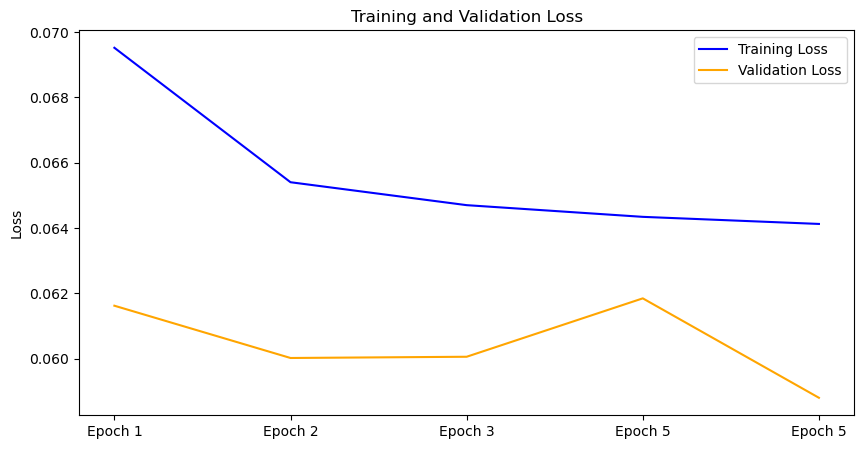

<IPython.core.display.Javascript object>

In [224]:
epoch_ticks = [0, 1, 2, 3, 4]
plt.figure(figsize=(10, 5))
plt.plot(train_epoch_means, label="Training Loss", color="blue")
plt.plot(val_epoch_means, label="Validation Loss", color="orange")
plt.xlabel("")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.xticks(epoch_ticks, ["Epoch 1", "Epoch 2", "Epoch 3", "Epoch 5", "Epoch 5"])
plt.show()

### Plotting confusion matrix

Based on values which were generated from running the models on validation data, confusion matrixes are created and presented as heatmaps bellow. 

In [204]:
conf_mat_trained = multilabel_confusion_matrix(y_true, y_val_pred_trained)
conf_mat_tuned = multilabel_confusion_matrix(y_true, y_val_pred_tuned)


<IPython.core.display.Javascript object>

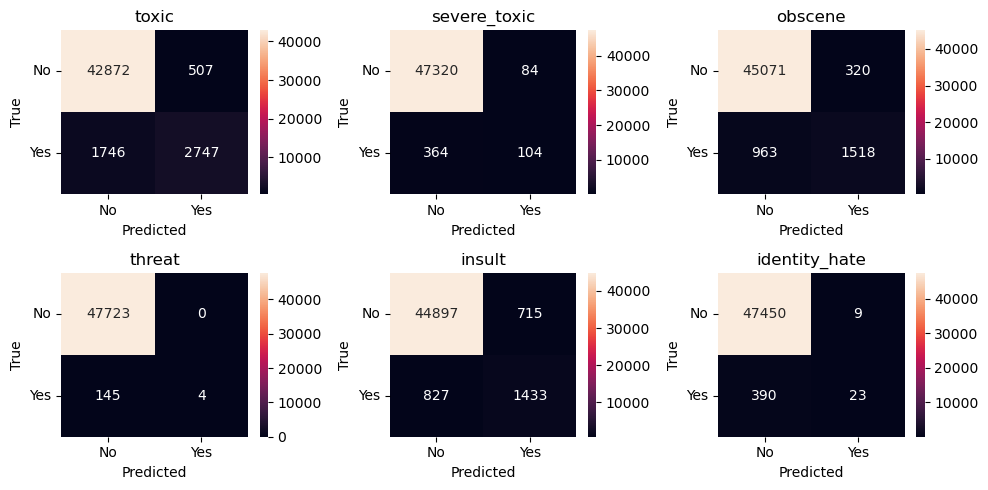

<IPython.core.display.Javascript object>

In [205]:
plt.figure(figsize=(10, 5))

for i, matrix in enumerate(conf_mat_trained):
    plt.subplot(2, 3, i + 1)

    sns.heatmap(matrix, annot=True, fmt="d", cbar=True)

    plt.title(f"{label_names[i]}")
    plt.xlabel("Predicted")
    plt.ylabel("True")

    tick_labels = ["No", "Yes"]
    plt.xticks(np.arange(2) + 0.5, tick_labels, rotation=0)
    plt.yticks(np.arange(2) + 0.5, tick_labels, rotation=0)


plt.tight_layout()
plt.show()

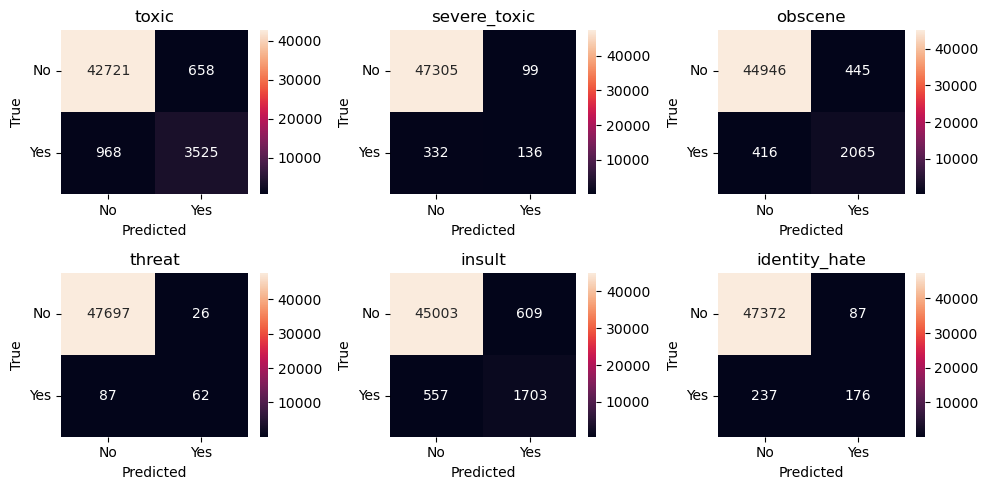

<IPython.core.display.Javascript object>

In [206]:
plt.figure(figsize=(10, 5))

for i, matrix in enumerate(conf_mat_tuned):
    plt.subplot(2, 3, i + 1)

    sns.heatmap(matrix, annot=True, fmt="d", cbar=True)

    plt.title(f"{label_names[i]}")
    plt.xlabel("Predicted")
    plt.ylabel("True")

    tick_labels = ["No", "Yes"]
    plt.xticks(np.arange(2) + 0.5, tick_labels, rotation=0)
    plt.yticks(np.arange(2) + 0.5, tick_labels, rotation=0)


plt.tight_layout()
plt.show()

### Classification report

In [207]:
classification_report_trained = classification_report(y_true, y_val_pred_trained, target_names=label_names)
print(classification_report_trained)


               precision    recall  f1-score   support

        toxic       0.84      0.61      0.71      4493
 severe_toxic       0.55      0.22      0.32       468
      obscene       0.83      0.61      0.70      2481
       threat       1.00      0.03      0.05       149
       insult       0.67      0.63      0.65      2260
identity_hate       0.72      0.06      0.10       413

    micro avg       0.78      0.57      0.66     10264
    macro avg       0.77      0.36      0.42     10264
 weighted avg       0.78      0.57      0.64     10264
  samples avg       0.05      0.05      0.05     10264



<IPython.core.display.Javascript object>

In [208]:
classification_report_tuned = classification_report(
    y_true, y_val_pred_tuned, target_names=label_names
)
print(classification_report_tuned)

               precision    recall  f1-score   support

        toxic       0.84      0.78      0.81      4493
 severe_toxic       0.58      0.29      0.39       468
      obscene       0.82      0.83      0.83      2481
       threat       0.70      0.42      0.52       149
       insult       0.74      0.75      0.74      2260
identity_hate       0.67      0.43      0.52       413

    micro avg       0.80      0.75      0.77     10264
    macro avg       0.73      0.58      0.64     10264
 weighted avg       0.79      0.75      0.77     10264
  samples avg       0.07      0.07      0.06     10264



<IPython.core.display.Javascript object>

It can be observed that the labels 'toxic' and 'obscene' have the highest precision and recall scores comparing to other labels (0.84 and 0.78 for toxic; and 0.82 and 0.83 for obscene). The label 'threat' and 'identity hate' have the lowest precision and recall scores (0.7 and 0.42 fro threat; and 0.67 and 0.43 for identity hate respectively).

In general, precision scores are higher thatn recall with the exception of the label 'obscene'.

that fine-tuning of the model has significantly improved recall scores for different labels at the expense of precision, and slightly improved average f1 scores. The micro average f1 score of the trained model (without fine-tuning) for all labels is 0.66 while the micro average f1 score of the fine-tuned model is 0.77. 

### Predictions on the test dataset

Finally, predictions on the test data, that that do not include labels, with the fine-tuned classifier are generated. In order to prevent memory overload, predictions are generated in randomly selected batches. For random selection of batches, SubsetRadomSampler is used. Data are loaded with random dataloader and run on the model, outputs of predictions are transformed with sigmoid function into probabilities for each label and then probabilities higher than 0.5 receive the value 1.

In [168]:
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=3
)

<IPython.core.display.Javascript object>

In [170]:
num_batches = 30
num_samples = num_batches * test_loader.batch_size
sampler = SubsetRandomSampler(indices=torch.randperm(len(test_loader.dataset))[:num_samples])


<IPython.core.display.Javascript object>

In [171]:
random_loader = DataLoader(
    test_loader.dataset, sampler=sampler, batch_size=test_loader.batch_size
)

<IPython.core.display.Javascript object>

In [172]:
all_outputs = []
all_sigmoids = []
all_preds = []
all_indices = []

start_time = time.time()

with torch.no_grad():
    for i, batch in enumerate(random_loader):
        batch = {
            k: v.to(device)
            for k, v in batch.items()
            if k in ["input_ids", "attention_mask"]
        }

        outputs = model_load2(**batch)
        sigmoids = torch.sigmoid(outputs)
        preds = (sigmoids > 0.5).to(torch.int)

        all_outputs.append(outputs.cpu())
        all_sigmoids.append(sigmoids.cpu())
        all_preds.append(preds.cpu())

        start_idx = i * random_loader.batch_size
        end_idx = start_idx + random_loader.batch_size
        batch_indices = sampler.indices[start_idx:end_idx]
        all_indices.extend(batch_indices)

all_outputs = torch.cat(all_outputs, 0)
all_sigmoids = torch.cat(all_sigmoids, 0)
all_preds = torch.cat(all_preds, 0)

end_time = time.time()
inference_time = end_time - start_time

print(f"Prediction time: {inference_time}")


Prediction time: 2.5442490577697754


<IPython.core.display.Javascript object>

Finally, the list of tensors of predictions is converted to the list of lists and the dataframe with columns of ids, comments and predicted labels is created. 

In [173]:
# Convert all_indices from list of tensors to list of integers
all_indices = [index.item() for index in all_indices]

# Extract labels from all_preds
# Convert tensor predictions to list of lists
all_preds_list = all_preds.tolist()

# Index the dataframe using the indices from all_indices
selected_df = test.iloc[all_indices].copy()

# Convert all_preds_list to a dataframe
preds_df = pd.DataFrame(all_preds_list, columns=[f"{label_names[i]}" for i in range(0, 6)])

# Reset the index of selected_df for concatenation
selected_df.reset_index(drop=True, inplace=True)

# Concatenate the original data with the predictions
predicted_df = pd.concat([selected_df, preds_df], axis=1)


<IPython.core.display.Javascript object>

In [174]:
predicted_inapr = predicted_df[
    (predicted_df["toxic"] == 1)
    | (predicted_df["severe_toxic"] == 1)
    | (predicted_df["obscene"] == 1)
    | (predicted_df["threat"] == 1)
    | (predicted_df["insult"] == 1)
    | (predicted_df["identity_hate"] == 1)
]

<IPython.core.display.Javascript object>

The output of comments which are classified as inappropriate (that has at least one 1 in the label values) is presented bellow. It can be observed that quite many comments from 30 randomly selected batches with size 5 (150 randomly selected comments in total) are labeled as inappropriate.

In [175]:
pd.set_option("display.max_colwidth", None)
for comment in predicted_inapr["comment_text"]:
    print(comment)
    print("")

  Deaths.  I dont understand why she is in deaths from typhus and murdered? these are two different things.

Ive added in the Kings and the Junta. Does it look better to you now?

GAGO TANGA PUTANG INA

Thanks very much, Clayoquot! I will post some more info on the Luna talk page, too.

Floaterectomy Is this procedure worth mentioning? httpwww.djo.harvard.eduprint.php?urlphysiciansoa1004print1

Who ever reads this is an idiot

 I included the GiveWell blog when I mentioned links to blog posts. I personally think that it all hinges on that one blog entry and that its reliability is subjective. Ill let Kudpung speak for himself, though. Ive probably butted in too far as it is so the trout stays! Im never opposed to a trouting anyway. I think a little silliness is good for productivity. Im suddenly craving fish and chips... 

the project must be preserved. 

 Merry Christmas  wishes you a Merry Christmas! Hi Elonka! I wish you a Merry Christmas and all the best in the new year. 

  Whats 

<IPython.core.display.Javascript object>

## Conclusions

The project provides the exploratory analysis and training of pretrained transformer models (Distilbert) for the purpose of multi-label classification of Wikipedia comments - that is, to train classifiers able to predict inapropriate comments (toxic, severe toxic, threat, obscene, insult, indentity hate).

The exploratory analysis revealed that:
- the majority of inappropriate comments are classified as expressing negative sentiment.
- the most used words in inappropriate comments are curse and hate speech words.

By examining the modeling results it can be observed that:
- the labels 'toxic' and 'obscene' have the highest precision and recall scores comparing to other labels (0.84 and 0.78 for toxic; and 0.82 and 0.83 for obscene). The label 'threat' and 'identity hate' have the lowest precision and recall scores (0.7 and 0.42 for threat; and 0.67 and 0.43 for identity hate respectively).
- precision scores are higher thatn recall with the exception of the label 'obscene'.
- the fine-tuning of the model has significantly improved recall scores for different labels at the expense of precision, and slightly improved average f1 scores:
- - The micro average f1 score of the trained model (without fine-tuning) for all labels is 0.66 while the micro average f1 score of the fine-tuned model is 0.77.
- the classifier could be used as a tool to identify inapproprate comments and users which make such comments in order to remove or block the comments and users or else.

#### Limitations and suggestions for improvement:

##### Limitations:

1. The models were trained with 5 epochs and fine-tuned with 5 epochs but the prediction scores could have been be improved if models were trained with higher numbers of epochs.
2. Only the Distilbert model was trained and fine-tuned.
3. It was not tested how models could perform if different numbers of batch sizes, different learning rates, or optimizers could be chosen.
4. Losses for model training on train and validation data were not logged, thus it was not possible to plot them after the restart of the kernel. Also, the class for getting time periods of training for each epoch was not used.

##### Suggestions for improvement:

1. To improve the prediction power of multi-label classification of Wikipedia comments while training models with different parameters (learning rates, optimizers), more epochs, and different batch sizes.
2. Other models such as Roberta could be trained and fine-tuned for the same multi-label classification purpose in order to compare the models and to choose the one with the best scores.

## References

1. ChatGPT.OpenAI, https://chat.openai.com/
2. Exploratory Data Analysis for Natural Language Processing: A Complete Guide to Python Tools, https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
3. Hugging Face, https://huggingface.co/
4. Toxic Comment Classification Challenge, https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge